In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
device_list = tf.test.gpu_device_name()
device_list

Mounted at /content/drive


'/device:GPU:0'

## Setting up environment

In [ ]:
!pip install --upgrade transformers==4.28.0
!pip install --upgrade datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.3 MB/s eta 0:00:

In [ ]:
!pip install -q datasets sentencepiece
!pip install sentencepiece
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.


## Import Libraries

In [ ]:
import os
import re
import io
from io import BytesIO
from typing import Any, List, Tuple
import random
import json

import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
import PIL
from PIL import Image, ImageDraw, ImageFont

import torch
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from transformers import VisionEncoderDecoderConfig, DonutProcessor, VisionEncoderDecoderModel, BartConfig
from sklearn.model_selection import train_test_split


## Getting the data

In [ ]:

dataset_path = "/content/drive/MyDrive/PFE_Master/data/donut/data"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'invoice': 0,
 'resume': 1,
 'receipt': 2,
 'table': 3,
 'handwriting': 4,
 'passport': 5}

## Data preparition

In [ ]:
# invoices
path_invoices = '/content/drive/MyDrive/PFE_Master/data/donut/data/invoice/'

# receipts
path_receipts = '/content/drive/MyDrive/PFE_Master/data/donut/data/receipt/'

# resume
path_resume = '/content/drive/MyDrive/PFE_Master/data/donut/data/resume/'

# passport
path_passport = '/content/drive/MyDrive/PFE_Master/data/donut/data/passport/'

# handwriting
path_handwriting = '/content/drive/MyDrive/PFE_Master/data/donut/data/handwriting/'

# table
path_table = '/content/drive/MyDrive/PFE_Master/data/donut/data/table/'

# create map
paths = [path_invoices, path_receipts, path_resume, path_passport,path_table, path_handwriting]
classes = ['invoice', 'receipt', 'resume', 'passport', 'table', 'handwriting']

In [ ]:
def img_str(path) :
  image = Image.open(path)
  image = image.convert('L')
  with BytesIO() as output:
    image.save(output, format='PNG')
    image_string = output.getvalue()
    return image_string

def str_img(image_string) :
  with BytesIO(image_string) as input:
    output_image = Image.open(input)
    return output_image


In [ ]:
import datasets
from PIL import Image

data = []


for idx, path in enumerate(paths):
    i=0
    classe = {"class" : classes[idx]}
    truth = {"gt_parse": classe}
    # truth to string
    truth = f'{truth}'
    for img in tqdm(os.listdir(path)):
      try:
        pil_img = Image.open(path+"/"+img).convert("RGB")
        pil_image = pil_img.resize((600, 400))
        img = np.asarray(pil_image)
        # flatten img
        img = img.flatten()
        data.append({'image': img, 'label': idx, 'ground_truth': truth})
        i+=1
        if i>351:
            break
      except PIL.UnidentifiedImageError:
            os.remove(path+"/"+img)

 88%|████████▊ | 351/398 [01:02<00:08,  5.62it/s]


In [ ]:
# data to dataframe
df = pd.DataFrame(data)
df['ground_truth'] = df['ground_truth'].apply(lambda x: x.replace("'", '"'))
df.dropna(inplace=True)
df.head()

,image,label,ground_truth
0,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0,"{""gt_parse"": {""class"": ""invoice""}}"
1,"[209, 209, 209, 209, 209, 209, 209, 209, 209, ...",0,"{""gt_parse"": {""class"": ""invoice""}}"
2,"[52, 52, 52, 52, 52, 52, 52, 52, 52, 51, 51, 5...",0,"{""gt_parse"": {""class"": ""invoice""}}"
3,"[231, 231, 231, 231, 231, 231, 231, 231, 231, ...",0,"{""gt_parse"": {""class"": ""invoice""}}"
4,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",0,"{""gt_parse"": {""class"": ""invoice""}}"


In [ ]:
df["image"] = df["image"].apply(lambda x : x.flatten())

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3)
df_eval, df_test = train_test_split(df_temp, test_size=0.5)

In [ ]:
from datasets import Dataset, DatasetDict, load_dataset

dataset_model = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "eval": Dataset.from_pandas(df_eval.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True))
})

In [ ]:
from transformers import VisionEncoderDecoderConfig

max_length = 8
# image_size = [2560, 1920]
# let's use a smaller image size (height, width) because otherwise OOM
# the higher the resolution, the better the results will be
# so if you have a big GPU, feel free to increase
image_size = [600, 400]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("nielsr/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [ ]:
from transformers import DonutProcessor, VisionEncoderDecoderModel, BartConfig

processor = DonutProcessor.from_pretrained("nielsr/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("nielsr/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.feature_extractor.do_align_long_axis = False

/usr/local/lib/python3.10/dist-packages/transformers/models/donut/processing_donut.py:186: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


In [ ]:
len(processor.tokenizer)

57525

In [ ]:
def add_tokens(list_of_tokens: List[str]):
    """
    Add tokens to tokenizer and resize the token embeddings
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
        model.decoder.resize_token_embeddings(len(processor.tokenizer))

In [ ]:
additional_tokens = ["<invoice/>", "<receipt/>", "<resume/>", "<passport/>"]

add_tokens(additional_tokens)

In [ ]:
processor.tokenizer.convert_tokens_to_ids(["<invoice/>", "<receipt/>", "<resume/>", "<passport/>"])

[57525, 57526, 57527, 57528]

In [ ]:
len(processor.tokenizer)

57529

In [ ]:
from torch.utils.data import Dataset
import io
class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset : DatasetDict,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "<s>",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = dataset[self.split]
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            ground_truth = json.loads(sample["ground_truth"])
            if "gt_parses" in ground_truth:  # when multiple ground truths are available, e.g., docvqa
                assert isinstance(ground_truth["gt_parses"], list)
                gt_jsons = ground_truth["gt_parses"]
            else:
                assert "gt_parse" in ground_truth and isinstance(ground_truth["gt_parse"], dict)
                gt_jsons = [ground_truth["gt_parse"]]

            self.gt_token_sequences.append(
                [
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + processor.tokenizer.eos_token
                    for gt_json in gt_jsons  # load json from list of json
                ]
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>", fr"</s_{k}>"])
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"<sep/>".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in additional_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj

    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))

    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]


        # pixel values (we remove the batch dimension)
        sample["image"] = np.array(sample["image"])
        print(sample["image"])
        sample["image"] = sample["image"].reshape((600, 400, 3))
        sample["image"] = Image.fromarray((sample["image"] * 255).astype(np.uint8))
        pixel_values = processor(sample["image"].convert("RGB"), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # labels, which are the input ids of the target sequence
        target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)

        encoding = dict(pixel_values=pixel_values,
                        labels=labels)

        return encoding

In [ ]:
train_dataset = DonutDataset(dataset_model, max_length=max_length,
                             split="train", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, # rvlcdip dataset is preprocessed, so no need for this
                             )

In [ ]:
eval_dataset = DonutDataset(dataset_model, max_length=max_length,
                             split="eval", task_start_token="<s_rvlcdip>", prompt_end_token="<s_rvlcdip>",
                             sort_json_key=False, # rvlcdip dataset is preprocessed, so no need for this
                             )

In [ ]:
from torch.utils.data import DataLoader

# I'm using a small batch size to make sure it fits in the memory Colab provides
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

In [ ]:
batch_train = next(iter(train_dataloader))
batch_eval = next(iter(eval_dataloader))

[254 254 254 ... 255 253 254]
[ 19  42 110 ...  19  42 110]


In [ ]:
for id in batch_train['labels'][0].tolist():
  if id != -100:
    print(processor.decode([id]))
  else:
    print(id)

<s_class>
table
</s_class>
</s>
-100
-100
-100
-100


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
# Convert to Hugging Face Dataset
hf_dataset_train = Dataset.from_dict({
    "data": batch_train["pixel_values"],
    "labels": batch_train["labels"]
})
# Convert to Hugging Face Dataset
hf_dataset_eval = Dataset.from_dict({
    "data": batch_eval["pixel_values"],
    "labels": batch_eval["labels"]
})

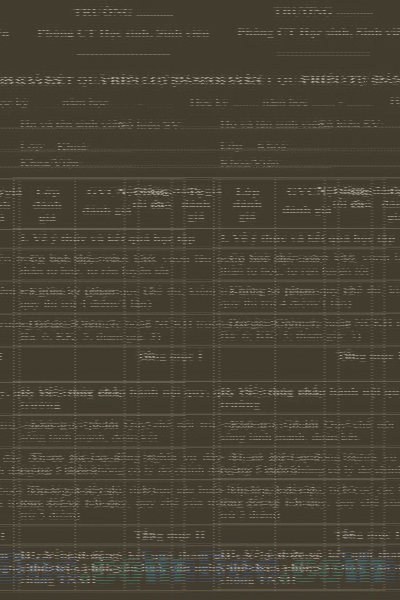

In [ ]:
from PIL import Image
import numpy as np

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# unnormalize
reconstructed_image = (batch_train['pixel_values'][0] * torch.tensor(std)[:, None, None]) + torch.tensor(mean)[:, None, None]
# unrescale
reconstructed_image = reconstructed_image * 255
# convert to numpy of shape HWC
reconstructed_image = torch.moveaxis(reconstructed_image, 0, -1)
image = Image.fromarray(reconstructed_image.numpy().astype(np.uint8))
image

In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s_rvlcdip>'])[0]

In [ ]:
# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_rvlcdip>


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)

for epoch in range(1):
    print("Epoch:", epoch+1)
    model.train()
    for i, batch in enumerate(tqdm(train_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]

        outputs = model(pixel_values=pixel_values,
                        labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if i % 100 == 0:
            print("Loss:", loss.item())

Epoch: 1


  0%|          | 0/1478 [00:00<?, ?it/s]

[ 93 113 109 ...  24  64 112]


  0%|          | 1/1478 [00:07<3:15:31,  7.94s/it]

Loss: 19.087045669555664


  0%|          | 2/1478 [00:08<1:27:17,  3.55s/it]

[254 254 254 ... 254 254 254]


  0%|          | 3/1478 [00:08<52:30,  2.14s/it]  

[205 205 205 ... 246 246 246]


  0%|          | 4/1478 [00:09<35:59,  1.46s/it]

[156 156 156 ... 243 243 243]


  0%|          | 5/1478 [00:09<27:37,  1.13s/it]

[  3   0   1 ... 194 195 190]


  0%|          | 6/1478 [00:10<24:03,  1.02it/s]

[211 211 211 ... 229 229 229]


  0%|          | 7/1478 [00:11<22:07,  1.11it/s]

[  0   0   0 ... 255 255 255]


  1%|          | 8/1478 [00:11<20:35,  1.19it/s]

[229 210 180 ...  48  23  23]


  1%|          | 9/1478 [00:12<19:41,  1.24it/s]

[255 255 255 ...   8   8   8]


  1%|          | 10/1478 [00:13<19:04,  1.28it/s]

[  1   2   3 ... 152 133 147]


  1%|          | 11/1478 [00:14<18:02,  1.36it/s]

[228 228 228 ...   1   1   1]


  1%|          | 12/1478 [00:14<17:23,  1.41it/s]

[255 255 255 ... 250 250 250]


  1%|          | 13/1478 [00:15<16:41,  1.46it/s]

[218 218 218 ... 218 218 218]


  1%|          | 14/1478 [00:15<14:50,  1.64it/s]

[255 255 255 ... 255 255 255]


  1%|          | 15/1478 [00:16<13:31,  1.80it/s]

[207 207 207 ... 118 118 118]


  1%|          | 16/1478 [00:16<12:39,  1.93it/s]

[229 229 229 ... 243 243 243]


  1%|          | 17/1478 [00:17<12:04,  2.02it/s]

[166 166 166 ... 243 243 243]


  1%|          | 18/1478 [00:17<11:38,  2.09it/s]

[223 225 224 ...  62  71  76]


  1%|▏         | 19/1478 [00:17<11:20,  2.14it/s]

[253 253 253 ... 255 255 255]


  1%|▏         | 20/1478 [00:18<11:08,  2.18it/s]

[5 5 5 ... 5 5 5]


  1%|▏         | 21/1478 [00:18<11:00,  2.21it/s]

[  8   8   8 ... 255 253 255]


  1%|▏         | 22/1478 [00:19<10:55,  2.22it/s]

[239 193 193 ... 239 155 168]


  2%|▏         | 23/1478 [00:19<10:47,  2.25it/s]

[255 255 255 ... 255 255 255]


  2%|▏         | 24/1478 [00:20<10:41,  2.27it/s]

[ 10  10  10 ... 140 140 140]


  2%|▏         | 25/1478 [00:20<10:41,  2.27it/s]

[170 170 170 ... 241 241 241]


  2%|▏         | 26/1478 [00:21<10:45,  2.25it/s]

[117 117 117 ... 190 190 190]


  2%|▏         | 27/1478 [00:21<10:45,  2.25it/s]

[5 5 5 ... 1 1 1]


  2%|▏         | 28/1478 [00:21<10:46,  2.24it/s]

[130 130 130 ... 247 247 247]


  2%|▏         | 29/1478 [00:22<10:49,  2.23it/s]

[1 1 1 ... 0 0 0]


  2%|▏         | 30/1478 [00:22<10:46,  2.24it/s]

[254 254 254 ... 255 255 255]


  2%|▏         | 31/1478 [00:23<10:51,  2.22it/s]

[255 255 255 ... 251 251 251]


  2%|▏         | 32/1478 [00:23<10:45,  2.24it/s]

[199 199 197 ... 195 194 192]


  2%|▏         | 33/1478 [00:24<10:43,  2.24it/s]

[184 186 183 ... 255 255 250]


  2%|▏         | 34/1478 [00:24<10:43,  2.24it/s]

[  0   0   0 ... 248 248 250]


  2%|▏         | 35/1478 [00:25<10:41,  2.25it/s]

[  8   8   8 ... 255 255 255]


  2%|▏         | 36/1478 [00:25<12:01,  2.00it/s]

[147 150 155 ...   2 141 179]


  3%|▎         | 37/1478 [00:26<13:37,  1.76it/s]

[100 100 100 ... 157 157 159]


  3%|▎         | 38/1478 [00:27<14:34,  1.65it/s]

[179 195 182 ...  85  85  79]


  3%|▎         | 39/1478 [00:27<15:30,  1.55it/s]

[  8   8   8 ... 252 254 249]


  3%|▎         | 40/1478 [00:28<16:09,  1.48it/s]

[250 252 251 ... 255 255 255]
[255 255 255 ... 255 255 255]


  3%|▎         | 42/1478 [00:30<16:29,  1.45it/s]

[255 255 255 ... 255 255 255]


  3%|▎         | 43/1478 [00:30<15:33,  1.54it/s]

[255 255 255 ... 255 255 255]


  3%|▎         | 44/1478 [00:31<14:03,  1.70it/s]

[61 61 61 ... 61 61 61]


  3%|▎         | 45/1478 [00:31<12:59,  1.84it/s]

[216 216 216 ... 241 241 241]


  3%|▎         | 46/1478 [00:31<12:15,  1.95it/s]

[ 77  77  77 ... 234 234 234]


  3%|▎         | 47/1478 [00:32<11:42,  2.04it/s]

[223 223 223 ... 248 248 248]


  3%|▎         | 48/1478 [00:32<11:23,  2.09it/s]

[91 92 84 ... 34 34 33]


  3%|▎         | 49/1478 [00:33<11:07,  2.14it/s]

[121 121 121 ... 128 128 128]


  3%|▎         | 50/1478 [00:33<11:11,  2.13it/s]

[191 184 202 ...  15   5  17]


  3%|▎         | 51/1478 [00:34<11:01,  2.16it/s]

[254 254 254 ... 255 253 254]


  4%|▎         | 52/1478 [00:34<10:54,  2.18it/s]

[197 197 197 ... 246 246 246]


  4%|▎         | 53/1478 [00:35<10:43,  2.21it/s]

[209 209 209 ... 241 241 241]


  4%|▎         | 54/1478 [00:35<10:33,  2.25it/s]

[252 252 252 ... 254 254 254]


  4%|▎         | 55/1478 [00:35<10:29,  2.26it/s]

[141 141 141 ... 254 254 254]


  4%|▍         | 56/1478 [00:36<10:27,  2.27it/s]

[255 255 244 ... 250 239 243]


  4%|▍         | 57/1478 [00:36<10:29,  2.26it/s]

[254 254 254 ...   1   1   1]


  4%|▍         | 58/1478 [00:37<10:25,  2.27it/s]

[ 81  99 103 ... 227 229 228]


  4%|▍         | 59/1478 [00:37<10:29,  2.26it/s]

[  3   2   0 ... 210 212 207]


  4%|▍         | 60/1478 [00:38<10:29,  2.25it/s]

[244 244 244 ... 217 217 217]


  4%|▍         | 61/1478 [00:38<10:38,  2.22it/s]

[222 222 222 ... 232 232 232]


  4%|▍         | 62/1478 [00:39<10:35,  2.23it/s]

[255 255 255 ... 255 255 255]


  4%|▍         | 63/1478 [00:39<10:31,  2.24it/s]

[255 255 255 ... 255 255 255]


  4%|▍         | 64/1478 [00:39<10:30,  2.24it/s]

[  8   8   8 ... 253 253 253]
[255 255 255 ... 255 255 255]


  4%|▍         | 66/1478 [00:41<12:28,  1.89it/s]

[254 254 254 ... 254 254 254]


  5%|▍         | 67/1478 [00:41<13:59,  1.68it/s]

[255 255 255 ... 255 255 255]


  5%|▍         | 68/1478 [00:42<14:54,  1.58it/s]

[176 176 176 ... 255 255 255]


  5%|▍         | 69/1478 [00:43<15:31,  1.51it/s]

[254 254 254 ... 254 254 254]


  5%|▍         | 70/1478 [00:44<16:09,  1.45it/s]

[255 255 255 ... 255 255 255]
[190 190 190 ... 204 204 204]


  5%|▍         | 72/1478 [00:45<15:58,  1.47it/s]

[175 173 150 ...   7   7   3]


  5%|▍         | 73/1478 [00:45<14:18,  1.64it/s]

[255 255 255 ... 255 255 255]


  5%|▌         | 74/1478 [00:46<13:04,  1.79it/s]

[ 54  54  54 ... 254 254 254]


  5%|▌         | 75/1478 [00:46<12:15,  1.91it/s]

[254 254 254 ... 254 254 254]


  5%|▌         | 76/1478 [00:47<11:45,  1.99it/s]

[254 254 254 ... 255 255 255]


  5%|▌         | 77/1478 [00:47<11:17,  2.07it/s]

[169 182 189 ... 171 173 167]


  5%|▌         | 78/1478 [00:48<11:09,  2.09it/s]

[5 5 5 ... 0 0 0]


  5%|▌         | 79/1478 [00:48<10:53,  2.14it/s]

[181 181 183 ...  24  22  36]


  5%|▌         | 80/1478 [00:48<10:46,  2.16it/s]

[254 254 254 ... 254 254 254]


  5%|▌         | 81/1478 [00:49<10:36,  2.19it/s]

[252 252 252 ... 252 252 252]


  6%|▌         | 82/1478 [00:49<10:30,  2.21it/s]

[218 218 216 ... 205 200 197]


  6%|▌         | 83/1478 [00:50<10:26,  2.23it/s]

[254 254 254 ... 254 254 254]


  6%|▌         | 84/1478 [00:50<10:25,  2.23it/s]

[ 93  93  93 ... 255 255 255]


  6%|▌         | 85/1478 [00:51<10:32,  2.20it/s]

[232 232 232 ... 248 248 248]


  6%|▌         | 86/1478 [00:51<10:29,  2.21it/s]

[105  42 113 ...   4   2   3]


  6%|▌         | 87/1478 [00:52<10:28,  2.21it/s]

[189 189 189 ... 243 243 243]


  6%|▌         | 88/1478 [00:52<10:22,  2.23it/s]

[218 218 218 ...   2   2   2]


  6%|▌         | 89/1478 [00:52<10:21,  2.23it/s]

[167 167 167 ... 250 250 250]


  6%|▌         | 90/1478 [00:53<10:19,  2.24it/s]

[208 208 208 ... 242 242 242]


  6%|▌         | 91/1478 [00:53<10:20,  2.23it/s]

[255 255 255 ... 234 234 234]


  6%|▌         | 92/1478 [00:54<10:20,  2.23it/s]

[200 200 200 ... 198 193 187]


  6%|▋         | 93/1478 [00:54<10:17,  2.24it/s]

[207 207 207 ... 249 249 249]


  6%|▋         | 94/1478 [00:55<10:21,  2.23it/s]

[231 245 246 ... 241 253 254]


  6%|▋         | 95/1478 [00:55<11:33,  1.99it/s]

[  0   0   0 ... 255 255 255]


  6%|▋         | 96/1478 [00:56<13:15,  1.74it/s]

[209 205 206 ... 168 168 166]


  7%|▋         | 97/1478 [00:57<14:14,  1.62it/s]

[  7   7   7 ... 255 255 255]


  7%|▋         | 98/1478 [00:58<15:08,  1.52it/s]

[228 228 228 ... 247 247 247]


  7%|▋         | 99/1478 [00:58<15:46,  1.46it/s]

[254 254 254 ... 254 254 254]


  7%|▋         | 100/1478 [00:59<15:46,  1.46it/s]

[255 255 255 ... 255 255 255]
[206 208 207 ...   1   1   1]


  7%|▋         | 101/1478 [01:00<16:37,  1.38it/s]

Loss: 0.6113716959953308


  7%|▋         | 102/1478 [01:00<14:43,  1.56it/s]

[189 189 189 ... 205 205 205]


  7%|▋         | 103/1478 [01:01<13:22,  1.71it/s]

[ 82 117  37 ... 243 242 237]


  7%|▋         | 104/1478 [01:01<12:20,  1.86it/s]

[133 121 135 ...  52  46  60]


  7%|▋         | 105/1478 [01:02<11:39,  1.96it/s]

[  0   0   0 ... 218 218 218]


  7%|▋         | 106/1478 [01:02<11:14,  2.03it/s]

[255 255 255 ... 255 255 255]


  7%|▋         | 107/1478 [01:02<10:54,  2.09it/s]

[13 14 16 ...  1  0  0]


  7%|▋         | 108/1478 [01:03<10:48,  2.11it/s]

[179 179 179 ... 255 255 255]


  7%|▋         | 109/1478 [01:03<10:46,  2.12it/s]

[165 165 165 ... 233 233 233]


  7%|▋         | 110/1478 [01:04<10:45,  2.12it/s]

[209 209 209 ... 229 229 229]


  8%|▊         | 111/1478 [01:04<10:37,  2.14it/s]

[200 198 204 ... 232 233 255]


  8%|▊         | 112/1478 [01:05<10:33,  2.16it/s]

[38 62 12 ...  0  0  0]


  8%|▊         | 113/1478 [01:05<10:26,  2.18it/s]

[255 255 255 ... 255 255 255]


  8%|▊         | 114/1478 [01:06<10:21,  2.19it/s]

[186 186 186 ... 204 204 204]


  8%|▊         | 115/1478 [01:06<10:17,  2.21it/s]

[137 137 137 ... 255 255 255]


  8%|▊         | 116/1478 [01:07<10:13,  2.22it/s]

[200 200 200 ... 215 215 215]


  8%|▊         | 117/1478 [01:07<10:10,  2.23it/s]

[114 114 114 ... 114 114 114]


  8%|▊         | 118/1478 [01:07<10:10,  2.23it/s]

[50 72 26 ... 50 72 26]


  8%|▊         | 119/1478 [01:08<10:08,  2.23it/s]

[  1   1   1 ... 148 148 148]


  8%|▊         | 120/1478 [01:08<10:05,  2.24it/s]

[237 229 218 ... 237 229 218]


  8%|▊         | 121/1478 [01:09<10:10,  2.22it/s]

[255 255 255 ... 219 219 219]


  8%|▊         | 122/1478 [01:09<10:03,  2.25it/s]

[254 254 254 ...  50  58 130]


  8%|▊         | 123/1478 [01:10<10:00,  2.26it/s]

[253 253 253 ... 233 233 233]


  8%|▊         | 124/1478 [01:10<10:59,  2.05it/s]

[255 255 255 ... 255 255 255]


  8%|▊         | 125/1478 [01:11<12:37,  1.79it/s]

[102  93 114 ...  47  36  42]


  9%|▊         | 126/1478 [01:12<13:42,  1.64it/s]

[183 183 183 ... 255 255 255]


  9%|▊         | 127/1478 [01:12<14:33,  1.55it/s]

[  0   0   0 ... 154 154 154]


  9%|▊         | 128/1478 [01:13<15:08,  1.49it/s]

[255 255 255 ...   5   5   5]


  9%|▊         | 129/1478 [01:14<15:19,  1.47it/s]

[255 255 255 ... 254 254 254]


  9%|▉         | 130/1478 [01:15<15:24,  1.46it/s]

[248 245 240 ... 248 245 240]


  9%|▉         | 131/1478 [01:15<14:31,  1.55it/s]

[217 217 217 ... 240 240 240]


  9%|▉         | 132/1478 [01:16<13:08,  1.71it/s]

[125 216  87 ... 125 216  87]


  9%|▉         | 133/1478 [01:16<12:11,  1.84it/s]

[52 52 52 ... 52 52 52]


  9%|▉         | 134/1478 [01:16<11:29,  1.95it/s]

[  2   0   1 ... 212 214 165]


  9%|▉         | 135/1478 [01:17<10:59,  2.04it/s]

[255 255 255 ... 255 255 255]


  9%|▉         | 136/1478 [01:17<10:52,  2.06it/s]

[218 218 218 ... 230 230 230]


  9%|▉         | 137/1478 [01:18<10:35,  2.11it/s]

[  0   0   0 ... 255 255 255]


  9%|▉         | 138/1478 [01:18<10:29,  2.13it/s]

[201 201 201 ... 243 243 243]


  9%|▉         | 139/1478 [01:19<10:18,  2.16it/s]

[247 247 247 ... 227 224 215]


  9%|▉         | 140/1478 [01:19<10:14,  2.18it/s]

[255 255 255 ...  75  75  77]


 10%|▉         | 141/1478 [01:20<10:09,  2.19it/s]

[150 150 150 ... 239 239 239]


 10%|▉         | 142/1478 [01:20<10:09,  2.19it/s]

[128 150 168 ...   1   1   1]


 10%|▉         | 143/1478 [01:21<10:13,  2.18it/s]

[125 129 140 ...   0   1   0]


 10%|▉         | 144/1478 [01:21<10:08,  2.19it/s]

[116 124 143 ... 138 146 165]


 10%|▉         | 145/1478 [01:21<10:09,  2.19it/s]

[211 211 211 ... 246 246 246]


 10%|▉         | 146/1478 [01:22<10:02,  2.21it/s]

[254 254 254 ... 254 254 254]


 10%|▉         | 147/1478 [01:22<10:05,  2.20it/s]

[196 196 196 ... 196 196 196]


 10%|█         | 148/1478 [01:23<09:57,  2.22it/s]

[182 182 182 ... 243 243 243]


 10%|█         | 149/1478 [01:23<09:59,  2.22it/s]

[ 79  79  79 ... 254 254 254]


 10%|█         | 150/1478 [01:24<09:57,  2.22it/s]

[255 255 255 ... 255 255 255]


 10%|█         | 151/1478 [01:24<09:57,  2.22it/s]

[231 231 231 ... 231 231 231]


 10%|█         | 152/1478 [01:25<09:56,  2.22it/s]

[254 254 254 ... 236 236 236]


 10%|█         | 153/1478 [01:25<10:21,  2.13it/s]

[255 255 255 ... 255 255 255]


 10%|█         | 154/1478 [01:26<12:21,  1.79it/s]

[190 207 215 ... 225 243 255]


 10%|█         | 155/1478 [01:27<13:42,  1.61it/s]

[61 61 61 ... 55 54 52]
[255 255 255 ...  55  55  55]


 11%|█         | 157/1478 [01:28<15:12,  1.45it/s]

[255 255 255 ... 255 255 255]
[ 5  5  5 ... 66 66 66]


 11%|█         | 158/1478 [01:29<15:30,  1.42it/s]

[201 201 201 ... 242 242 242]


 11%|█         | 160/1478 [01:30<15:01,  1.46it/s]

[  8   8   8 ... 255 255 255]


 11%|█         | 161/1478 [01:31<13:25,  1.64it/s]

[255 255 255 ... 252 252 252]


 11%|█         | 162/1478 [01:31<12:19,  1.78it/s]

[255 255 255 ... 255 255 255]


 11%|█         | 163/1478 [01:32<11:33,  1.90it/s]

[173 173 173 ... 234 234 234]


 11%|█         | 164/1478 [01:32<10:58,  2.00it/s]

[133 129 126 ... 114 125 107]


 11%|█         | 165/1478 [01:33<10:36,  2.06it/s]

[189 189 189 ... 205 205 205]


 11%|█         | 166/1478 [01:33<10:19,  2.12it/s]

[192 160 171 ... 199 167 172]


 11%|█▏        | 167/1478 [01:33<10:05,  2.17it/s]

[212 212 212 ... 250 250 250]


 11%|█▏        | 168/1478 [01:34<10:03,  2.17it/s]

[254 254 254 ... 253 253 253]


 11%|█▏        | 169/1478 [01:34<10:03,  2.17it/s]

[225 225 225 ... 218 218 218]


 12%|█▏        | 170/1478 [01:35<09:58,  2.19it/s]

[211 211 211 ... 247 247 247]


 12%|█▏        | 171/1478 [01:35<09:52,  2.20it/s]

[144 144 144 ...  75  75  75]


 12%|█▏        | 172/1478 [01:36<09:50,  2.21it/s]

[ 65  65  65 ... 254 254 254]


 12%|█▏        | 173/1478 [01:36<09:49,  2.22it/s]

[254 167   0 ...  55  46  47]


 12%|█▏        | 174/1478 [01:37<09:47,  2.22it/s]

[135 135 135 ... 242 242 242]


 12%|█▏        | 175/1478 [01:37<09:43,  2.23it/s]

[244 244 244 ... 244 244 244]


 12%|█▏        | 176/1478 [01:37<09:41,  2.24it/s]

[255 255 255 ... 255 255 255]


 12%|█▏        | 177/1478 [01:38<09:41,  2.24it/s]

[201 201 201 ...   0   0   0]


 12%|█▏        | 178/1478 [01:38<09:38,  2.25it/s]

[218 219 223 ... 255 255 255]


 12%|█▏        | 179/1478 [01:39<09:43,  2.23it/s]

[234 223 239 ... 134 119 138]


 12%|█▏        | 180/1478 [01:39<09:40,  2.24it/s]

[5 5 5 ... 5 5 5]


 12%|█▏        | 181/1478 [01:40<09:42,  2.23it/s]

[255 255 255 ... 255 255 255]


 12%|█▏        | 182/1478 [01:40<09:38,  2.24it/s]

[255 255 255 ... 255 255 255]


 12%|█▏        | 183/1478 [01:41<11:03,  1.95it/s]

[31 31 31 ... 31 31 31]


 12%|█▏        | 184/1478 [01:42<12:35,  1.71it/s]

[255 255 255 ... 255 255 255]


 13%|█▎        | 185/1478 [01:42<13:37,  1.58it/s]

[194 194 194 ... 255 255 255]


 13%|█▎        | 186/1478 [01:43<14:18,  1.51it/s]

[3 3 3 ... 6 6 6]


 13%|█▎        | 187/1478 [01:44<14:46,  1.46it/s]

[255 255 255 ... 255 255 255]


 13%|█▎        | 189/1478 [01:45<14:46,  1.45it/s]

[188 199 201 ... 135 139 140]
[172 176 179 ... 203 203 203]


 13%|█▎        | 190/1478 [01:46<13:27,  1.59it/s]

[ 75 119  40 ... 254 241 251]


 13%|█▎        | 191/1478 [01:46<12:17,  1.75it/s]

[185 195 185 ... 160 169 152]


 13%|█▎        | 192/1478 [01:46<11:22,  1.88it/s]

[206 206 206 ... 170 170 170]


 13%|█▎        | 193/1478 [01:47<10:48,  1.98it/s]

[  0   0   0 ... 255 255 255]


 13%|█▎        | 194/1478 [01:47<10:28,  2.04it/s]

[255 255 255 ... 255 255 251]


 13%|█▎        | 195/1478 [01:48<10:06,  2.12it/s]

[222 222 222 ... 240 240 240]


 13%|█▎        | 196/1478 [01:48<09:56,  2.15it/s]

[189 201 217 ...  11  13  16]


 13%|█▎        | 197/1478 [01:49<09:49,  2.17it/s]

[201 212 208 ... 176 194 178]


 13%|█▎        | 198/1478 [01:49<09:43,  2.19it/s]

[  7   7   7 ... 253 253 253]


 13%|█▎        | 199/1478 [01:50<09:40,  2.20it/s]

[30  6 40 ...  8  6  7]


 14%|█▎        | 200/1478 [01:50<10:03,  2.12it/s]

[ 35  35  35 ... 255 255 255]
[224 224 224 ... 242 242 242]


 14%|█▎        | 201/1478 [01:51<10:49,  1.97it/s]

Loss: 1.3338998556137085


 14%|█▎        | 202/1478 [01:51<10:28,  2.03it/s]

[65 65 65 ... 65 65 65]


 14%|█▎        | 203/1478 [01:52<10:08,  2.10it/s]

[255 255 255 ... 255 255 255]


 14%|█▍        | 204/1478 [01:52<09:56,  2.13it/s]

[246 246 246 ... 255 255 255]


 14%|█▍        | 205/1478 [01:53<09:44,  2.18it/s]

[26 33 43 ... 42 32 22]


 14%|█▍        | 206/1478 [01:53<09:32,  2.22it/s]

[ 74  74  74 ... 164 164 164]


 14%|█▍        | 207/1478 [01:53<09:27,  2.24it/s]

[152 152 152 ... 245 245 245]


 14%|█▍        | 208/1478 [01:54<09:22,  2.26it/s]

[173 173 173 ... 249 249 249]


 14%|█▍        | 209/1478 [01:54<09:21,  2.26it/s]

[214 214 214 ... 247 247 247]


 14%|█▍        | 210/1478 [01:55<09:22,  2.25it/s]

[4 4 4 ... 5 5 5]


 14%|█▍        | 211/1478 [01:55<09:22,  2.25it/s]

[164 164 166 ... 255 245 219]


 14%|█▍        | 212/1478 [01:56<10:16,  2.05it/s]

[8 8 8 ... 0 0 0]


 14%|█▍        | 213/1478 [01:56<11:43,  1.80it/s]

[209 209 209 ... 255 255 255]


 14%|█▍        | 214/1478 [01:57<12:50,  1.64it/s]

[239 239 239 ...  44  20   0]


 15%|█▍        | 215/1478 [01:58<13:40,  1.54it/s]

[  0   0   0 ... 255 255 255]


 15%|█▍        | 216/1478 [01:59<14:13,  1.48it/s]

[233 233 233 ... 248 248 248]
[221 221 221 ... 227 227 227]


 15%|█▍        | 218/1478 [02:00<14:26,  1.45it/s]

[205 205 205 ... 236 236 236]


 15%|█▍        | 219/1478 [02:01<13:40,  1.53it/s]

[23 36  0 ...  3 13  1]


 15%|█▍        | 220/1478 [02:01<12:23,  1.69it/s]

[29 51 13 ... 14 17 13]


 15%|█▍        | 221/1478 [02:02<11:28,  1.83it/s]

[  8   8   8 ... 253 253 253]


 15%|█▌        | 222/1478 [02:02<10:47,  1.94it/s]

[  1   1   1 ... 252 252 252]


 15%|█▌        | 223/1478 [02:02<10:22,  2.02it/s]

[ 60  60  60 ... 244 244 244]


 15%|█▌        | 224/1478 [02:03<10:03,  2.08it/s]

[202 202 202 ...  20  20  20]


 15%|█▌        | 225/1478 [02:03<09:54,  2.11it/s]

[0 0 0 ... 2 2 2]


 15%|█▌        | 226/1478 [02:04<09:44,  2.14it/s]

[246 255 255 ... 254 255 245]


 15%|█▌        | 227/1478 [02:04<09:43,  2.14it/s]

[  6   5  10 ... 163 158 178]


 15%|█▌        | 228/1478 [02:05<09:34,  2.18it/s]

[0 0 0 ... 4 2 1]


 15%|█▌        | 229/1478 [02:05<09:27,  2.20it/s]

[216 216 216 ... 239 239 239]


 16%|█▌        | 230/1478 [02:06<09:24,  2.21it/s]

[239 239 237 ...   0   0   0]


 16%|█▌        | 231/1478 [02:06<09:18,  2.23it/s]

[159 159 159 ... 237 237 237]


 16%|█▌        | 232/1478 [02:06<09:19,  2.23it/s]

[  9   9   9 ... 252 252 252]


 16%|█▌        | 233/1478 [02:07<09:17,  2.23it/s]

[254 254 254 ... 255 255 255]


 16%|█▌        | 234/1478 [02:07<09:16,  2.24it/s]

[220 220 220 ... 238 238 238]


 16%|█▌        | 235/1478 [02:08<09:12,  2.25it/s]

[254 254 254 ...  22  22  22]


 16%|█▌        | 236/1478 [02:08<09:20,  2.21it/s]

[130 122 156 ...  75  65  79]


 16%|█▌        | 237/1478 [02:09<09:27,  2.19it/s]

[255 255 255 ... 255 255 255]


 16%|█▌        | 238/1478 [02:09<09:21,  2.21it/s]

[212 212 212 ... 225 225 225]


 16%|█▌        | 239/1478 [02:10<09:18,  2.22it/s]

[ 75  75  75 ... 254 254 254]


 16%|█▌        | 240/1478 [02:10<09:13,  2.24it/s]

[255 255 255 ... 255 255 255]


 16%|█▋        | 241/1478 [02:11<09:26,  2.19it/s]

[255 253 255 ...  37  41  40]


 16%|█▋        | 242/1478 [02:11<11:01,  1.87it/s]

[137 137 137 ... 255 255 255]


 16%|█▋        | 243/1478 [02:12<12:17,  1.67it/s]

[255 255 255 ... 255 255 255]


 17%|█▋        | 244/1478 [02:13<13:11,  1.56it/s]

[209 209 209 ... 238 238 238]


 17%|█▋        | 245/1478 [02:13<13:43,  1.50it/s]

[224 224 224 ... 243 243 243]
[255 255 255 ... 146 146 146]


 17%|█▋        | 247/1478 [02:15<14:05,  1.46it/s]

[146 146 146 ... 146 146 146]


 17%|█▋        | 248/1478 [02:16<13:52,  1.48it/s]

[122 128 124 ...  15  16  20]


 17%|█▋        | 249/1478 [02:16<12:23,  1.65it/s]

[221 221 221 ... 241 241 241]


 17%|█▋        | 250/1478 [02:16<11:22,  1.80it/s]

[241 241 241 ... 223 223 223]


 17%|█▋        | 251/1478 [02:17<10:40,  1.92it/s]

[199 199 199 ... 237 237 237]


 17%|█▋        | 252/1478 [02:17<10:08,  2.01it/s]

[  0   0   0 ... 195 195 195]


 17%|█▋        | 253/1478 [02:18<09:50,  2.07it/s]

[228 228 228 ... 228 228 228]


 17%|█▋        | 254/1478 [02:18<09:35,  2.13it/s]

[255 255 255 ... 255 255 255]


 17%|█▋        | 255/1478 [02:19<09:24,  2.17it/s]

[5 5 5 ... 1 1 1]


 17%|█▋        | 256/1478 [02:19<09:18,  2.19it/s]

[255 255 255 ... 255 255 255]


 17%|█▋        | 257/1478 [02:20<09:18,  2.19it/s]

[ 8  0  0 ... 10  0  0]


 17%|█▋        | 258/1478 [02:20<09:13,  2.20it/s]

[106 106 130 ... 141 142 162]


 18%|█▊        | 259/1478 [02:20<09:08,  2.22it/s]

[220 220 220 ... 242 242 242]


 18%|█▊        | 260/1478 [02:21<09:13,  2.20it/s]

[228 228 228 ... 237 237 237]


 18%|█▊        | 261/1478 [02:21<09:11,  2.21it/s]

[148 148 148 ... 155 155 155]


 18%|█▊        | 262/1478 [02:22<09:10,  2.21it/s]

[196 198 174 ... 130 134 111]


 18%|█▊        | 263/1478 [02:22<09:10,  2.21it/s]

[198 198 198 ... 255 255 255]


 18%|█▊        | 264/1478 [02:23<09:08,  2.21it/s]

[242 239 232 ... 227 216 210]


 18%|█▊        | 265/1478 [02:23<09:05,  2.22it/s]

[67 67 67 ... 67 67 67]


 18%|█▊        | 266/1478 [02:24<09:00,  2.24it/s]

[228 228 228 ... 249 249 249]


 18%|█▊        | 267/1478 [02:24<09:04,  2.22it/s]

[184 184 184 ... 255 255 255]


 18%|█▊        | 268/1478 [02:24<09:04,  2.22it/s]

[ 2  3  4 ... 37 31 15]


 18%|█▊        | 269/1478 [02:25<09:02,  2.23it/s]

[255 255 255 ... 255 255 255]


 18%|█▊        | 270/1478 [02:25<09:02,  2.23it/s]

[255 144  75 ... 254 254 254]


 18%|█▊        | 271/1478 [02:26<09:58,  2.02it/s]

[254 254 254 ... 254 254 254]
[108 108 108 ... 109 109 109]


 18%|█▊        | 273/1478 [02:27<12:34,  1.60it/s]

[64 76 52 ... 39 48 31]


 19%|█▊        | 274/1478 [02:28<13:14,  1.52it/s]

[255 255 255 ... 255 255 255]


 19%|█▊        | 275/1478 [02:29<13:42,  1.46it/s]

[179 179 179 ... 255 255 255]


 19%|█▊        | 276/1478 [02:30<13:48,  1.45it/s]

[ 56  56  56 ... 223 223 223]
[229 229 229 ... 233 233 233]


 19%|█▉        | 278/1478 [02:31<13:03,  1.53it/s]

[109 109 109 ... 255 255 255]


 19%|█▉        | 279/1478 [02:31<11:47,  1.69it/s]

[200 200 200 ... 255 255 255]


 19%|█▉        | 280/1478 [02:32<10:50,  1.84it/s]

[225 225 225 ... 238 238 238]


 19%|█▉        | 281/1478 [02:32<10:15,  1.94it/s]

[120  66  92 ... 102  20  42]


 19%|█▉        | 282/1478 [02:33<09:48,  2.03it/s]

[144 144 144 ... 252 252 252]


 19%|█▉        | 283/1478 [02:33<09:34,  2.08it/s]

[213 213 213 ... 238 238 238]


 19%|█▉        | 284/1478 [02:34<09:20,  2.13it/s]

[254 254 254 ... 254 254 254]


 19%|█▉        | 285/1478 [02:34<09:13,  2.16it/s]

[254 254 254 ... 254 254 254]


 19%|█▉        | 286/1478 [02:34<09:05,  2.19it/s]

[255 255 255 ... 255 255 255]


 19%|█▉        | 287/1478 [02:35<09:12,  2.15it/s]

[ 50  50  50 ... 237 237 237]


 19%|█▉        | 288/1478 [02:35<09:05,  2.18it/s]

[248 245 240 ... 248 245 240]


 20%|█▉        | 289/1478 [02:36<09:01,  2.20it/s]

[255 255 255 ... 255 255 255]


 20%|█▉        | 290/1478 [02:36<08:59,  2.20it/s]

[6 6 6 ... 1 1 1]


 20%|█▉        | 291/1478 [02:37<08:56,  2.21it/s]

[227 227 227 ... 236 236 236]


 20%|█▉        | 292/1478 [02:37<08:58,  2.20it/s]

[  0   0   0 ... 253 253 253]


 20%|█▉        | 293/1478 [02:38<08:54,  2.22it/s]

[255 255 255 ... 255 255 255]


 20%|█▉        | 294/1478 [02:38<08:54,  2.21it/s]

[254 254 254 ... 254 254 254]


 20%|█▉        | 295/1478 [02:39<08:54,  2.21it/s]

[185 185 185 ...  39  39  39]


 20%|██        | 296/1478 [02:39<08:52,  2.22it/s]

[228 228 228 ... 228 228 228]


 20%|██        | 297/1478 [02:39<08:56,  2.20it/s]

[ 92  62  52 ... 110  78  77]


 20%|██        | 298/1478 [02:40<08:53,  2.21it/s]

[  7   7   7 ... 135 135 135]


 20%|██        | 299/1478 [02:40<08:54,  2.21it/s]

[219 219 219 ... 233 233 233]


 20%|██        | 300/1478 [02:41<09:13,  2.13it/s]

[  8   8   8 ... 255 255 255]
[201 201 201 ... 229 229 229]


 20%|██        | 301/1478 [02:42<11:29,  1.71it/s]

Loss: 0.42753854393959045


 20%|██        | 302/1478 [02:42<12:18,  1.59it/s]

[182 182 182 ... 254 254 254]


 21%|██        | 303/1478 [02:43<13:04,  1.50it/s]

[255 255 255 ... 255 255 255]


 21%|██        | 304/1478 [02:44<13:38,  1.43it/s]

[255 255 255 ... 255 255 255]


 21%|██        | 305/1478 [02:45<13:48,  1.42it/s]

[153 154 148 ...  14  10  13]
[  0   0   0 ... 233 233 233]


 21%|██        | 307/1478 [02:46<13:18,  1.47it/s]

[204 204 204 ... 231 231 231]


 21%|██        | 308/1478 [02:47<12:00,  1.62it/s]

[255 255 255 ... 255 255 255]


 21%|██        | 309/1478 [02:47<11:11,  1.74it/s]

[166 166 166 ... 241 241 241]


 21%|██        | 310/1478 [02:47<10:29,  1.85it/s]

[220 220 220 ... 235 235 235]


 21%|██        | 311/1478 [02:48<09:55,  1.96it/s]

[225 225 225 ... 236 236 236]


 21%|██        | 312/1478 [02:48<09:36,  2.02it/s]

[255 255 255 ... 255 255 255]


 21%|██        | 313/1478 [02:49<09:16,  2.09it/s]

[255 255 255 ... 255 255 255]


 21%|██        | 314/1478 [02:49<09:04,  2.14it/s]

[181 181 181 ... 159 159 159]


 21%|██▏       | 315/1478 [02:50<08:56,  2.17it/s]

[254 254 254 ... 254 254 254]


 21%|██▏       | 316/1478 [02:50<08:52,  2.18it/s]

[115 136 127 ... 115 137 125]


 21%|██▏       | 317/1478 [02:51<08:50,  2.19it/s]

[ 5  5  5 ... 29 29 29]


 22%|██▏       | 318/1478 [02:51<08:50,  2.18it/s]

[112 112 112 ... 255 255 255]


 22%|██▏       | 319/1478 [02:52<08:50,  2.19it/s]

[157 157 157 ... 234 234 234]


 22%|██▏       | 320/1478 [02:52<08:51,  2.18it/s]

[255 255 255 ... 154 154 154]


 22%|██▏       | 321/1478 [02:52<08:50,  2.18it/s]

[255 255 255 ... 255 255 255]


 22%|██▏       | 322/1478 [02:53<08:44,  2.20it/s]

[254 254 254 ... 252 252 252]


 22%|██▏       | 323/1478 [02:53<08:43,  2.21it/s]

[101 107  93 ... 160 166 156]


 22%|██▏       | 324/1478 [02:54<08:42,  2.21it/s]

[120 115 112 ...  11   6   8]


 22%|██▏       | 325/1478 [02:54<08:38,  2.22it/s]

[187 187 187 ... 201 201 201]


 22%|██▏       | 326/1478 [02:55<08:37,  2.23it/s]

[1 1 1 ... 1 1 1]


 22%|██▏       | 327/1478 [02:55<08:40,  2.21it/s]

[254 254 254 ... 254 254 254]


 22%|██▏       | 328/1478 [02:56<08:41,  2.20it/s]

[254 255 248 ... 241 255 244]


 22%|██▏       | 329/1478 [02:56<08:49,  2.17it/s]

[255 255 255 ... 252 252 252]


 22%|██▏       | 330/1478 [02:57<10:15,  1.86it/s]

[147 147 147 ... 236 236 236]


 22%|██▏       | 331/1478 [02:58<11:29,  1.66it/s]

[255 255 255 ... 255 255 255]


 22%|██▏       | 332/1478 [02:58<12:14,  1.56it/s]

[222 222 222 ... 225 225 225]


 23%|██▎       | 333/1478 [02:59<12:52,  1.48it/s]

[13 13 13 ...  9  9  9]


 23%|██▎       | 334/1478 [03:00<13:12,  1.44it/s]

[68 68 68 ... 68 68 68]


 23%|██▎       | 335/1478 [03:00<13:11,  1.44it/s]

[254 254 254 ... 252 252 252]


 23%|██▎       | 336/1478 [03:01<13:03,  1.46it/s]

[254 254 254 ... 254 254 254]


 23%|██▎       | 337/1478 [03:02<11:40,  1.63it/s]

[255 255 255 ... 255 255 255]


 23%|██▎       | 338/1478 [03:02<10:45,  1.77it/s]

[245 245 245 ... 255 255 255]


 23%|██▎       | 339/1478 [03:02<10:06,  1.88it/s]

[255 255 255 ... 224 224 224]


 23%|██▎       | 340/1478 [03:03<09:41,  1.96it/s]

[233 248 245 ...  62  54  58]


 23%|██▎       | 341/1478 [03:03<09:21,  2.03it/s]

[4 4 4 ... 1 1 1]


 23%|██▎       | 342/1478 [03:04<09:07,  2.07it/s]

[133 133 133 ... 255 255 255]


 23%|██▎       | 343/1478 [03:04<08:56,  2.11it/s]

[190 190 190 ... 254 254 254]


 23%|██▎       | 344/1478 [03:05<08:45,  2.16it/s]

[ 11  18  10 ... 198 207 188]


 23%|██▎       | 345/1478 [03:05<08:53,  2.12it/s]

[255 255 255 ... 255 255 255]


 23%|██▎       | 346/1478 [03:06<08:47,  2.15it/s]

[0 0 0 ... 1 0 0]


 23%|██▎       | 347/1478 [03:06<08:49,  2.14it/s]

[  8   7   7 ... 141 141 141]


 24%|██▎       | 348/1478 [03:07<08:40,  2.17it/s]

[206 206 206 ... 205 205 205]


 24%|██▎       | 349/1478 [03:07<08:41,  2.16it/s]

[112 109 126 ... 116 139 147]


 24%|██▎       | 350/1478 [03:07<08:35,  2.19it/s]

[255 255 255 ... 255 255 255]


 24%|██▎       | 351/1478 [03:08<08:35,  2.18it/s]

[ 41  41  41 ... 255 255 255]


 24%|██▍       | 352/1478 [03:08<08:33,  2.19it/s]

[  0   0   0 ... 255 255 255]


 24%|██▍       | 353/1478 [03:09<08:39,  2.17it/s]

[  8   9   8 ... 253 253 253]


 24%|██▍       | 354/1478 [03:09<08:35,  2.18it/s]

[192 192 192 ... 245 245 245]


 24%|██▍       | 355/1478 [03:10<08:27,  2.21it/s]

[84 84 84 ... 76 76 76]


 24%|██▍       | 356/1478 [03:10<08:28,  2.21it/s]

[254 254 254 ... 254 254 254]


 24%|██▍       | 357/1478 [03:11<08:24,  2.22it/s]

[255 251 253 ... 151 145 181]


 24%|██▍       | 358/1478 [03:11<08:27,  2.21it/s]

[219 219 219 ... 242 242 242]


 24%|██▍       | 359/1478 [03:12<09:58,  1.87it/s]

[255 255 255 ... 255 255 255]


 24%|██▍       | 360/1478 [03:13<11:00,  1.69it/s]

[159 159 159 ... 239 239 239]


 24%|██▍       | 361/1478 [03:13<11:43,  1.59it/s]

[153 153 153 ... 255 255 255]


 24%|██▍       | 362/1478 [03:14<12:19,  1.51it/s]

[164 164 164 ... 255 255 255]


 25%|██▍       | 363/1478 [03:15<12:46,  1.45it/s]

[  6   6   6 ... 179 179 177]


 25%|██▍       | 364/1478 [03:15<12:49,  1.45it/s]

[208 208 206 ... 203 195 193]


 25%|██▍       | 365/1478 [03:16<12:44,  1.46it/s]

[255 255 255 ... 255 255 255]


 25%|██▍       | 366/1478 [03:17<11:33,  1.60it/s]

[255 255 255 ... 255 255 255]


 25%|██▍       | 367/1478 [03:17<10:31,  1.76it/s]

[245 245 245 ... 245 245 245]


 25%|██▍       | 368/1478 [03:18<09:57,  1.86it/s]

[243 244 246 ... 250 251 255]


 25%|██▍       | 369/1478 [03:18<09:29,  1.95it/s]

[246 242 239 ...   0   0   0]


 25%|██▌       | 370/1478 [03:18<09:10,  2.01it/s]

[  0   6   0 ...  18 104  55]


 25%|██▌       | 371/1478 [03:19<08:51,  2.08it/s]

[254 254 254 ... 254 254 254]


 25%|██▌       | 372/1478 [03:19<08:42,  2.12it/s]

[125 216  87 ... 125 216  87]


 25%|██▌       | 373/1478 [03:20<08:31,  2.16it/s]

[208 208 208 ... 239 239 239]


 25%|██▌       | 374/1478 [03:20<08:25,  2.18it/s]

[255 255 255 ... 255 255 255]


 25%|██▌       | 375/1478 [03:21<08:27,  2.17it/s]

[108 108 108 ...  32  32  32]


 25%|██▌       | 376/1478 [03:21<08:25,  2.18it/s]

[206 206 206 ... 236 236 236]


 26%|██▌       | 377/1478 [03:22<08:28,  2.16it/s]

[220 220 220 ... 235 235 235]


 26%|██▌       | 378/1478 [03:22<08:25,  2.18it/s]

[126 126 126 ... 255 255 255]


 26%|██▌       | 379/1478 [03:23<08:21,  2.19it/s]

[184 184 184 ... 241 241 241]


 26%|██▌       | 380/1478 [03:23<08:19,  2.20it/s]

[199 199 199 ... 232 232 232]


 26%|██▌       | 381/1478 [03:23<08:21,  2.19it/s]

[192 192 192 ... 211 211 211]


 26%|██▌       | 382/1478 [03:24<08:17,  2.20it/s]

[31 30 25 ... 12 16 12]


 26%|██▌       | 383/1478 [03:24<08:21,  2.18it/s]

[208 208 208 ... 242 242 242]


 26%|██▌       | 384/1478 [03:25<08:16,  2.20it/s]

[255 255 255 ... 255 255 255]


 26%|██▌       | 385/1478 [03:25<08:14,  2.21it/s]

[193 193 193 ... 241 241 241]


 26%|██▌       | 386/1478 [03:26<08:15,  2.21it/s]

[ 98  92 126 ...   8  15   8]


 26%|██▌       | 387/1478 [03:26<08:14,  2.21it/s]

[231 231 231 ... 231 231 231]


 26%|██▋       | 388/1478 [03:27<09:20,  1.94it/s]

[224 204 196 ...   8   0   1]


 26%|██▋       | 389/1478 [03:28<10:40,  1.70it/s]

[172 191 189 ... 195 202 213]


 26%|██▋       | 390/1478 [03:28<11:39,  1.55it/s]

[191 191 191 ...  30  30  30]


 26%|██▋       | 391/1478 [03:29<12:08,  1.49it/s]

[255 255 255 ... 255 255 255]


 27%|██▋       | 392/1478 [03:30<12:31,  1.44it/s]

[226 226 226 ... 232 232 232]
[135 143 135 ... 150 145 149]


 27%|██▋       | 394/1478 [03:31<12:26,  1.45it/s]

[164 161 142 ...  14   7   8]


 27%|██▋       | 395/1478 [03:32<11:43,  1.54it/s]

[  0   0   0 ... 252 252 252]


 27%|██▋       | 396/1478 [03:32<10:38,  1.70it/s]

[255 255 255 ... 255 255 255]


 27%|██▋       | 397/1478 [03:33<09:52,  1.82it/s]

[244 244 239 ... 106  92  88]


 27%|██▋       | 398/1478 [03:33<09:21,  1.92it/s]

[ 0  0  0 ...  8 10  4]


 27%|██▋       | 399/1478 [03:34<09:05,  1.98it/s]

[208 199 194 ... 215 207 212]


 27%|██▋       | 400/1478 [03:34<08:44,  2.06it/s]

[248 248 248 ... 254 254 254]
[  0   0   0 ... 255 255 253]


 27%|██▋       | 401/1478 [03:35<09:14,  1.94it/s]

Loss: 1.1332837343215942


 27%|██▋       | 402/1478 [03:35<08:52,  2.02it/s]

[0 0 0 ... 1 1 1]


 27%|██▋       | 403/1478 [03:36<08:37,  2.08it/s]

[159 159 159 ... 158 158 158]


 27%|██▋       | 404/1478 [03:36<08:34,  2.09it/s]

[12 12 12 ... 25 25 25]


 27%|██▋       | 405/1478 [03:36<08:24,  2.13it/s]

[82 75 73 ... 64 65 59]


 27%|██▋       | 406/1478 [03:37<08:17,  2.16it/s]

[0 0 0 ... 0 0 0]


 28%|██▊       | 407/1478 [03:37<08:15,  2.16it/s]

[125 125 125 ... 189 189 189]


 28%|██▊       | 408/1478 [03:38<08:19,  2.14it/s]

[248 245 240 ... 248 245 240]


 28%|██▊       | 409/1478 [03:38<08:12,  2.17it/s]

[255 255 255 ... 255 255 255]


 28%|██▊       | 410/1478 [03:39<08:10,  2.18it/s]

[255 255 255 ... 255 255 255]


 28%|██▊       | 411/1478 [03:39<08:05,  2.20it/s]

[164 164 164 ... 255 255 255]


 28%|██▊       | 412/1478 [03:40<07:58,  2.23it/s]

[164 164 164 ... 255 255 255]


 28%|██▊       | 413/1478 [03:40<07:59,  2.22it/s]

[135 126 109 ... 119 110  95]


 28%|██▊       | 414/1478 [03:41<08:00,  2.22it/s]

[254 254 254 ... 254 254 254]


 28%|██▊       | 415/1478 [03:41<08:01,  2.21it/s]

[254 254 254 ... 254 254 254]


 28%|██▊       | 416/1478 [03:41<08:00,  2.21it/s]

[254 254 254 ... 254 254 254]


 28%|██▊       | 417/1478 [03:42<09:11,  1.92it/s]

[245 245 245 ... 245 245 245]


 28%|██▊       | 418/1478 [03:43<10:26,  1.69it/s]

[8 8 8 ... 0 0 0]


 28%|██▊       | 419/1478 [03:44<11:14,  1.57it/s]

[  8   8   8 ... 252 252 252]


 28%|██▊       | 420/1478 [03:44<11:45,  1.50it/s]

[255 255 255 ... 249 249 249]


 28%|██▊       | 421/1478 [03:45<12:07,  1.45it/s]

[255 255 255 ... 255 255 255]


 29%|██▊       | 422/1478 [03:46<12:11,  1.44it/s]

[240 254 254 ... 232 223 218]


 29%|██▊       | 424/1478 [03:47<11:16,  1.56it/s]

[254 254 254 ... 254 254 254]
[255 255 255 ... 255 255 255]


 29%|██▉       | 425/1478 [03:47<10:26,  1.68it/s]

[151 151 151 ... 129 129 129]


 29%|██▉       | 426/1478 [03:48<09:38,  1.82it/s]

[201 201 201 ... 255 255 255]


 29%|██▉       | 427/1478 [03:48<09:11,  1.90it/s]

[187 176 158 ... 106 101  82]


 29%|██▉       | 428/1478 [03:49<08:46,  2.00it/s]

[253 253 253 ... 255 255 255]


 29%|██▉       | 429/1478 [03:49<08:31,  2.05it/s]

[255 255 255 ...  54  54  54]


 29%|██▉       | 430/1478 [03:50<08:17,  2.11it/s]

[234 234 234 ... 234 234 234]


 29%|██▉       | 431/1478 [03:50<08:11,  2.13it/s]

[77 77 77 ... 73 73 73]


 29%|██▉       | 432/1478 [03:51<08:04,  2.16it/s]

[  9   9   9 ... 253 253 253]


 29%|██▉       | 433/1478 [03:51<08:03,  2.16it/s]

[255 255 255 ... 255 255 255]


 29%|██▉       | 434/1478 [03:52<07:55,  2.19it/s]

[126 126 126 ...   5   5   5]


 29%|██▉       | 435/1478 [03:52<07:51,  2.21it/s]

[255 255 255 ... 105 105 105]


 29%|██▉       | 436/1478 [03:52<07:52,  2.20it/s]

[255 255 255 ... 115 115 115]


 30%|██▉       | 437/1478 [03:53<07:48,  2.22it/s]

[212 212 212 ... 244 244 244]


 30%|██▉       | 438/1478 [03:53<07:48,  2.22it/s]

[197 149 149 ... 253 215 224]


 30%|██▉       | 439/1478 [03:54<07:45,  2.23it/s]

[195 173 185 ...  15  14  25]


 30%|██▉       | 440/1478 [03:54<07:46,  2.23it/s]

[156 156 156 ... 234 234 234]


 30%|██▉       | 441/1478 [03:55<07:44,  2.23it/s]

[108 110  97 ...  25  25   8]


 30%|██▉       | 442/1478 [03:55<07:42,  2.24it/s]

[255 255 255 ... 255 255 255]


 30%|██▉       | 443/1478 [03:56<07:44,  2.23it/s]

[  5   5   5 ... 255 255 255]


 30%|███       | 444/1478 [03:56<07:41,  2.24it/s]

[255 255 255 ... 255 255 255]


 30%|███       | 445/1478 [03:56<07:43,  2.23it/s]

[147 160 153 ...   9  11  12]


 30%|███       | 446/1478 [03:57<08:15,  2.08it/s]

[254 254 254 ... 254 254 254]


 30%|███       | 447/1478 [03:58<09:40,  1.78it/s]

[218 218 218 ... 218 218 218]


 30%|███       | 448/1478 [03:59<10:33,  1.63it/s]

[255 255 255 ... 255 255 255]


 30%|███       | 449/1478 [03:59<11:15,  1.52it/s]

[210 210 210 ... 232 232 232]


 30%|███       | 450/1478 [04:00<11:39,  1.47it/s]

[201 201 201 ... 230 230 230]


 31%|███       | 451/1478 [04:01<11:52,  1.44it/s]

[  6   9  18 ... 250 250 250]
[166 166 166 ... 200 200 200]


 31%|███       | 453/1478 [04:02<11:20,  1.51it/s]

[ 14  14  14 ... 252 252 252]


 31%|███       | 454/1478 [04:02<10:16,  1.66it/s]

[205 205 205 ... 240 240 240]


 31%|███       | 455/1478 [04:03<09:28,  1.80it/s]

[178 178 178 ... 238 238 238]


 31%|███       | 456/1478 [04:03<08:56,  1.91it/s]

[221 221 221 ... 236 236 236]


 31%|███       | 457/1478 [04:04<08:30,  2.00it/s]

[254 254 254 ... 254 254 254]


 31%|███       | 458/1478 [04:04<08:14,  2.06it/s]

[255 255 255 ... 255 255 255]


 31%|███       | 459/1478 [04:05<08:06,  2.09it/s]

[196 196 196 ... 255 255 255]


 31%|███       | 460/1478 [04:05<07:57,  2.13it/s]

[  0   0   0 ... 254 254 254]


 31%|███       | 461/1478 [04:06<07:54,  2.15it/s]

[255 255 255 ... 255 255 255]


 31%|███▏      | 462/1478 [04:06<07:53,  2.15it/s]

[  8   8   8 ... 255 255 255]


 31%|███▏      | 463/1478 [04:07<07:51,  2.15it/s]

[160 160 160 ... 241 241 241]


 31%|███▏      | 464/1478 [04:07<07:47,  2.17it/s]

[  1   1   0 ... 189 189 184]


 31%|███▏      | 465/1478 [04:07<07:49,  2.16it/s]

[255 255 255 ... 255 255 255]


 32%|███▏      | 466/1478 [04:08<07:45,  2.18it/s]

[159 159 159 ... 240 240 240]


 32%|███▏      | 467/1478 [04:08<07:40,  2.20it/s]

[197 197 197 ... 224 224 224]


 32%|███▏      | 468/1478 [04:09<07:44,  2.18it/s]

[255 255 255 ... 255 255 255]


 32%|███▏      | 469/1478 [04:09<07:40,  2.19it/s]

[255 255 255 ... 255 255 255]


 32%|███▏      | 470/1478 [04:10<07:39,  2.19it/s]

[  9   9   9 ... 181 181 181]


 32%|███▏      | 471/1478 [04:10<07:37,  2.20it/s]

[232 216 216 ... 180 180 180]


 32%|███▏      | 472/1478 [04:11<07:35,  2.21it/s]

[255 255 255 ... 255 255 255]


 32%|███▏      | 473/1478 [04:11<07:32,  2.22it/s]

[254 254 254 ... 255 255 255]


 32%|███▏      | 474/1478 [04:12<07:29,  2.23it/s]

[195 195 195 ... 238 238 238]


 32%|███▏      | 475/1478 [04:12<07:44,  2.16it/s]

[227 247 236 ... 219 245 236]


 32%|███▏      | 476/1478 [04:13<09:09,  1.82it/s]

[138 138 138 ... 251 251 251]


 32%|███▏      | 477/1478 [04:14<10:10,  1.64it/s]

[255 255 255 ... 255 255 255]


 32%|███▏      | 478/1478 [04:14<10:52,  1.53it/s]

[103  96  28 ...  16  16  16]


 32%|███▏      | 479/1478 [04:15<11:14,  1.48it/s]

[254 254 254 ... 254 254 254]


 32%|███▏      | 480/1478 [04:16<11:26,  1.45it/s]

[245 237 241 ...  99 112 102]


 33%|███▎      | 481/1478 [04:16<11:26,  1.45it/s]

[158 158 158 ... 230 230 230]


 33%|███▎      | 482/1478 [04:17<11:12,  1.48it/s]

[164 164 164 ... 244 244 244]


 33%|███▎      | 483/1478 [04:18<10:12,  1.62it/s]

[  8   8   8 ... 255 255 255]


 33%|███▎      | 484/1478 [04:18<09:22,  1.77it/s]

[69 69 69 ... 69 69 69]


 33%|███▎      | 485/1478 [04:18<08:50,  1.87it/s]

[  0   0   0 ... 255 255 255]


 33%|███▎      | 486/1478 [04:19<08:28,  1.95it/s]

[209 209 209 ... 239 239 239]


 33%|███▎      | 487/1478 [04:19<08:10,  2.02it/s]

[129   0 126 ... 129   0 126]


 33%|███▎      | 488/1478 [04:20<07:58,  2.07it/s]

[84 83 35 ... 94 93 87]


 33%|███▎      | 489/1478 [04:20<07:48,  2.11it/s]

[165 165 165 ... 217 217 217]


 33%|███▎      | 490/1478 [04:21<07:40,  2.15it/s]

[43 43 43 ... 44 44 44]


 33%|███▎      | 491/1478 [04:21<07:40,  2.14it/s]

[254 254 254 ... 254 254 254]


 33%|███▎      | 492/1478 [04:22<07:35,  2.17it/s]

[211 211 211 ... 211 211 211]


 33%|███▎      | 493/1478 [04:22<07:33,  2.17it/s]

[255 255 255 ... 255 255 255]


 33%|███▎      | 494/1478 [04:23<07:27,  2.20it/s]

[ 79  79  79 ... 254 254 254]


 33%|███▎      | 495/1478 [04:23<07:26,  2.20it/s]

[255 255 255 ... 255 255 255]


 34%|███▎      | 496/1478 [04:23<07:23,  2.21it/s]

[255 255 255 ... 255 255 255]


 34%|███▎      | 497/1478 [04:24<07:24,  2.21it/s]

[200 200 200 ... 176 167 152]


 34%|███▎      | 498/1478 [04:24<07:24,  2.21it/s]

[254 254 254 ... 151  11  24]


 34%|███▍      | 499/1478 [04:25<07:24,  2.20it/s]

[134 134 122 ...  53  54  46]


 34%|███▍      | 500/1478 [04:25<07:24,  2.20it/s]

[219 219 219 ... 255 255 255]
[  0   0   0 ... 255 255 255]


 34%|███▍      | 502/1478 [04:26<07:50,  2.07it/s]

Loss: 1.4502657651901245
[ 58  58  58 ... 255 255 255]


 34%|███▍      | 503/1478 [04:27<07:38,  2.12it/s]

[11 11 11 ... 27 27 27]


 34%|███▍      | 504/1478 [04:27<08:00,  2.03it/s]

[  7   8  12 ... 138 142 151]


 34%|███▍      | 505/1478 [04:28<09:11,  1.77it/s]

[255 255 255 ... 255 255 255]


 34%|███▍      | 506/1478 [04:29<10:00,  1.62it/s]

[ 43  43  43 ... 255 255 255]


 34%|███▍      | 507/1478 [04:30<10:40,  1.52it/s]

[211 211 211 ... 205 205 205]


 34%|███▍      | 508/1478 [04:30<11:11,  1.44it/s]

[ 92 158  71 ...   7  22   7]


 34%|███▍      | 509/1478 [04:31<11:13,  1.44it/s]

[130 130 130 ... 244 244 244]


 35%|███▍      | 510/1478 [04:32<11:09,  1.44it/s]

[250 250 250 ... 250 250 250]


 35%|███▍      | 511/1478 [04:32<10:54,  1.48it/s]

[255 254 251 ... 253 255 254]


 35%|███▍      | 512/1478 [04:33<09:49,  1.64it/s]

[189 189 189 ... 246 246 246]


 35%|███▍      | 513/1478 [04:33<09:05,  1.77it/s]

[178 169 140 ... 137 124  71]


 35%|███▍      | 514/1478 [04:34<08:29,  1.89it/s]

[181 181 181 ... 246 246 246]


 35%|███▍      | 515/1478 [04:34<08:06,  1.98it/s]

[  0   0   0 ... 255 255 255]


 35%|███▍      | 516/1478 [04:35<07:57,  2.01it/s]

[  0   0   0 ... 234 249 255]


 35%|███▍      | 517/1478 [04:35<07:43,  2.08it/s]

[5 5 5 ... 1 1 1]


 35%|███▌      | 518/1478 [04:36<07:35,  2.11it/s]

[255 255 255 ... 255 255 255]


 35%|███▌      | 519/1478 [04:36<07:26,  2.15it/s]

[219 219 219 ... 238 238 238]


 35%|███▌      | 520/1478 [04:36<07:26,  2.15it/s]

[  3   3   3 ... 240 240 240]


 35%|███▌      | 521/1478 [04:37<07:23,  2.16it/s]

[  0 136 255 ...  23 125 241]


 35%|███▌      | 522/1478 [04:37<07:23,  2.16it/s]

[ 84  84  84 ... 255 255 255]


 35%|███▌      | 523/1478 [04:38<07:18,  2.18it/s]

[231 231 231 ... 223 223 223]


 35%|███▌      | 524/1478 [04:38<07:16,  2.19it/s]

[231 231 231 ... 238 238 238]


 36%|███▌      | 525/1478 [04:39<07:13,  2.20it/s]

[254 254 254 ... 254 254 254]


 36%|███▌      | 526/1478 [04:39<07:15,  2.19it/s]

[255 255 255 ... 255 255 255]


 36%|███▌      | 527/1478 [04:40<07:11,  2.20it/s]

[254 241 251 ...  11  34  12]


 36%|███▌      | 528/1478 [04:40<07:12,  2.20it/s]

[  0   0   0 ... 254 254 254]


 36%|███▌      | 529/1478 [04:41<07:20,  2.16it/s]

[255 255 255 ... 255 255 255]


 36%|███▌      | 530/1478 [04:41<07:24,  2.13it/s]

[176 174 178 ... 130 122 119]


 36%|███▌      | 531/1478 [04:41<07:20,  2.15it/s]

[190 190 190 ... 154 154 154]


 36%|███▌      | 532/1478 [04:42<07:14,  2.18it/s]

[200 200 200 ...   1   1   1]


 36%|███▌      | 533/1478 [04:42<07:33,  2.08it/s]

[254 254 254 ... 254 254 254]


 36%|███▌      | 534/1478 [04:43<08:45,  1.80it/s]

[255 255 255 ... 255 255 255]


 36%|███▌      | 535/1478 [04:44<09:40,  1.63it/s]

[255 255 255 ... 255 255 255]


 36%|███▋      | 536/1478 [04:45<10:16,  1.53it/s]

[213 171 234 ...  90  89  95]


 36%|███▋      | 537/1478 [04:45<10:43,  1.46it/s]

[240 240 240 ... 240 240 240]


 36%|███▋      | 538/1478 [04:46<10:54,  1.44it/s]

[175 185 187 ... 131  98  91]


 36%|███▋      | 539/1478 [04:47<10:55,  1.43it/s]

[ 10  10  10 ... 255 255 255]


 37%|███▋      | 540/1478 [04:48<10:41,  1.46it/s]

[163 163 163 ... 240 240 240]


 37%|███▋      | 541/1478 [04:48<09:34,  1.63it/s]

[239 227 208 ... 252 255 255]


 37%|███▋      | 542/1478 [04:48<08:49,  1.77it/s]

[198 198 198 ... 228 228 228]


 37%|███▋      | 543/1478 [04:49<08:17,  1.88it/s]

[19 19 19 ... 29 29 27]


 37%|███▋      | 544/1478 [04:49<07:55,  1.97it/s]

[240 240 240 ... 254 254 254]


 37%|███▋      | 545/1478 [04:50<07:38,  2.04it/s]

[255 255 255 ... 255 255 255]


 37%|███▋      | 546/1478 [04:50<07:24,  2.10it/s]

[210 210 210 ... 244 244 244]


 37%|███▋      | 547/1478 [04:51<07:16,  2.13it/s]

[ 86 123  89 ... 108 117  64]


 37%|███▋      | 548/1478 [04:51<07:25,  2.09it/s]

[251 253 252 ... 207 206 211]


 37%|███▋      | 549/1478 [04:52<07:14,  2.14it/s]

[111  99 134 ...   8   4   5]


 37%|███▋      | 550/1478 [04:52<07:07,  2.17it/s]

[15 15 15 ... 34 34 34]


 37%|███▋      | 551/1478 [04:53<07:05,  2.18it/s]

[215 215 215 ... 233 233 233]


 37%|███▋      | 552/1478 [04:53<07:03,  2.19it/s]

[255 255 255 ... 255 255 255]


 37%|███▋      | 553/1478 [04:53<06:59,  2.20it/s]

[255 255 255 ... 255 255 255]


 37%|███▋      | 554/1478 [04:54<07:00,  2.20it/s]

[225 225 225 ... 230 230 230]


 38%|███▊      | 555/1478 [04:54<06:57,  2.21it/s]

[198 216 200 ...  28  33  39]


 38%|███▊      | 556/1478 [04:55<06:55,  2.22it/s]

[207 204 215 ... 228 222 234]


 38%|███▊      | 557/1478 [04:55<06:56,  2.21it/s]

[  1  38  31 ... 254 254 254]


 38%|███▊      | 558/1478 [04:56<06:56,  2.21it/s]

[255 255 255 ... 255 255 255]


 38%|███▊      | 559/1478 [04:56<06:55,  2.21it/s]

[254 254 254 ... 254 254 254]
[  8   8   8 ... 254 254 254]


 38%|███▊      | 561/1478 [04:57<07:36,  2.01it/s]

[211 186 163 ... 195 153 145]


 38%|███▊      | 562/1478 [04:58<08:13,  1.86it/s]

[255 255 255 ... 255 255 255]


 38%|███▊      | 563/1478 [04:59<09:10,  1.66it/s]

[255 255 255 ...  78  78  78]


 38%|███▊      | 564/1478 [04:59<09:46,  1.56it/s]

[213 213 213 ... 213 213 213]


 38%|███▊      | 565/1478 [05:00<10:12,  1.49it/s]

[242 242 242 ...  40  40  40]


 38%|███▊      | 566/1478 [05:01<10:29,  1.45it/s]

[255 255 255 ... 163 163 163]


 38%|███▊      | 567/1478 [05:02<10:28,  1.45it/s]

[202 202 202 ... 222 222 222]
[192 189 180 ...   0   4   3]


 38%|███▊      | 569/1478 [05:03<09:50,  1.54it/s]

[199 199 199 ... 204 204 204]


 39%|███▊      | 570/1478 [05:03<09:03,  1.67it/s]

[255 255 255 ... 227 227 227]


 39%|███▊      | 571/1478 [05:04<08:23,  1.80it/s]

[254 254 254 ... 254 254 254]


 39%|███▊      | 572/1478 [05:04<07:55,  1.90it/s]

[ 40  40  40 ... 156 156 156]


 39%|███▉      | 573/1478 [05:05<07:34,  1.99it/s]

[204 195  89 ... 103 113  65]


 39%|███▉      | 574/1478 [05:05<07:21,  2.05it/s]

[223 223 223 ... 234 234 234]


 39%|███▉      | 575/1478 [05:06<07:10,  2.10it/s]

[255 255 255 ... 208 208 208]


 39%|███▉      | 576/1478 [05:06<07:02,  2.14it/s]

[221 221 221 ... 221 221 221]


 39%|███▉      | 577/1478 [05:06<06:59,  2.15it/s]

[208 208 208 ... 236 236 236]


 39%|███▉      | 578/1478 [05:07<06:52,  2.18it/s]

[ 11  11  11 ... 254 254 254]


 39%|███▉      | 579/1478 [05:07<06:57,  2.16it/s]

[172 172 172 ... 245 245 245]


 39%|███▉      | 580/1478 [05:08<06:52,  2.18it/s]

[206 208 207 ... 197 193 184]


 39%|███▉      | 581/1478 [05:08<06:52,  2.18it/s]

[255 255 255 ... 255 255 255]


 39%|███▉      | 582/1478 [05:09<06:49,  2.19it/s]

[  0   0   0 ... 253 253 253]


 39%|███▉      | 583/1478 [05:09<06:58,  2.14it/s]

[255 255 255 ... 255 255 255]


 40%|███▉      | 584/1478 [05:10<07:01,  2.12it/s]

[255 255 255 ... 255 255 255]


 40%|███▉      | 585/1478 [05:10<06:56,  2.14it/s]

[213 224 207 ...  15  16  10]


 40%|███▉      | 586/1478 [05:11<06:51,  2.17it/s]

[ 40  40  40 ... 124 124 124]


 40%|███▉      | 587/1478 [05:11<06:48,  2.18it/s]

[220 220 220 ... 240 240 240]


 40%|███▉      | 588/1478 [05:12<06:57,  2.13it/s]

[164 164 164 ... 255 255 255]


 40%|███▉      | 589/1478 [05:12<06:51,  2.16it/s]

[237 237 237 ... 255 255 255]


 40%|███▉      | 590/1478 [05:12<06:50,  2.17it/s]

[255 255 255 ...  55  55  55]


 40%|███▉      | 591/1478 [05:13<07:45,  1.90it/s]

[237 237 237 ... 237 237 237]


 40%|████      | 592/1478 [05:14<08:44,  1.69it/s]

[5 5 5 ... 1 1 1]


 40%|████      | 593/1478 [05:15<09:26,  1.56it/s]

[215 215 215 ... 250 250 250]


 40%|████      | 594/1478 [05:15<09:55,  1.48it/s]

[  0   0   0 ... 247 247 247]


 40%|████      | 595/1478 [05:16<10:15,  1.44it/s]

[255 255 255 ... 121 121 121]


 40%|████      | 596/1478 [05:17<10:18,  1.43it/s]

[117 210 129 ...  21 155  84]
[255 255 255 ... 252 252 252]


 40%|████      | 598/1478 [05:18<09:37,  1.52it/s]

[206 213 210 ... 151 150 148]


 41%|████      | 599/1478 [05:19<08:45,  1.67it/s]

[255 255 255 ... 255 255 255]


 41%|████      | 600/1478 [05:19<08:06,  1.80it/s]

[  8   8   8 ... 251 251 251]
[164 164 164 ... 254 254 254]


 41%|████      | 601/1478 [05:20<08:16,  1.77it/s]

Loss: 0.24924203753471375


 41%|████      | 602/1478 [05:20<07:45,  1.88it/s]

[178 178 178 ... 231 231 231]


 41%|████      | 603/1478 [05:21<07:26,  1.96it/s]

[213 213 213 ... 227 227 227]


 41%|████      | 604/1478 [05:21<07:16,  2.00it/s]

[209 209 209 ... 229 229 229]


 41%|████      | 605/1478 [05:21<07:04,  2.06it/s]

[170 170 170 ... 255 255 255]


 41%|████      | 606/1478 [05:22<06:55,  2.10it/s]

[220 220 220 ... 219 219 219]


 41%|████      | 607/1478 [05:22<06:50,  2.12it/s]

[  0   0   0 ... 255 255 255]


 41%|████      | 608/1478 [05:23<06:46,  2.14it/s]

[61 61 61 ... 56 56 56]


 41%|████      | 609/1478 [05:23<06:49,  2.12it/s]

[  0   0   0 ... 255 255 255]


 41%|████▏     | 610/1478 [05:24<06:46,  2.14it/s]

[175 175 175 ... 241 241 241]


 41%|████▏     | 611/1478 [05:24<06:44,  2.15it/s]

[213 213 213 ... 208 208 208]


 41%|████▏     | 612/1478 [05:25<06:43,  2.15it/s]

[208 208 208 ... 242 242 242]


 41%|████▏     | 613/1478 [05:25<06:39,  2.16it/s]

[228 230 229 ... 205 206 208]


 42%|████▏     | 614/1478 [05:26<06:36,  2.18it/s]

[  0   0   0 ... 143 141 153]


 42%|████▏     | 615/1478 [05:26<06:33,  2.19it/s]

[254 254 254 ... 254 254 254]


 42%|████▏     | 616/1478 [05:26<06:31,  2.20it/s]

[97 94 89 ...  3  0  2]


 42%|████▏     | 617/1478 [05:27<06:32,  2.19it/s]

[133 133 133 ... 241 241 241]


 42%|████▏     | 618/1478 [05:27<06:31,  2.20it/s]

[177  90 106 ... 139  87 100]


 42%|████▏     | 619/1478 [05:28<06:34,  2.18it/s]

[151 158 184 ...   9  18  25]


 42%|████▏     | 620/1478 [05:29<07:44,  1.85it/s]

[201 201 201 ... 237 237 237]


 42%|████▏     | 621/1478 [05:29<08:41,  1.64it/s]

[203 200 193 ...  61  78  63]


 42%|████▏     | 622/1478 [05:30<09:15,  1.54it/s]

[  9   9   9 ... 252 254 249]


 42%|████▏     | 623/1478 [05:31<09:37,  1.48it/s]

[253 212 206 ... 253 212 206]


 42%|████▏     | 624/1478 [05:32<09:59,  1.43it/s]

[134 137 130 ... 174 167 174]
[ 76  76  76 ... 255 255 255]


 42%|████▏     | 626/1478 [05:33<09:54,  1.43it/s]

[243 243 243 ... 251 251 251]


 42%|████▏     | 627/1478 [05:33<08:51,  1.60it/s]

[249 190 208 ... 209 207 210]


 42%|████▏     | 628/1478 [05:34<08:14,  1.72it/s]

[255 255 255 ... 255 255 255]


 43%|████▎     | 629/1478 [05:34<07:41,  1.84it/s]

[158 158 158 ... 247 247 247]


 43%|████▎     | 630/1478 [05:35<07:16,  1.94it/s]

[254 254 254 ... 255 255 255]


 43%|████▎     | 631/1478 [05:35<07:01,  2.01it/s]

[255 255 255 ... 255 255 255]


 43%|████▎     | 632/1478 [05:36<06:47,  2.07it/s]

[47 47 47 ... 92 92 92]


 43%|████▎     | 633/1478 [05:36<06:43,  2.10it/s]

[210 210 210 ... 255 255 255]


 43%|████▎     | 634/1478 [05:37<06:34,  2.14it/s]

[  0   0   0 ... 253 254 236]


 43%|████▎     | 635/1478 [05:37<06:35,  2.13it/s]

[187 198 200 ... 162 164 161]


 43%|████▎     | 636/1478 [05:38<06:31,  2.15it/s]

[73 73 65 ... 44 43 48]


 43%|████▎     | 637/1478 [05:38<06:27,  2.17it/s]

[ 95 145 206 ... 105 145 180]


 43%|████▎     | 638/1478 [05:38<06:23,  2.19it/s]

[200 200 200 ... 200 200 200]


 43%|████▎     | 639/1478 [05:39<06:21,  2.20it/s]

[205 218 234 ... 215 232 252]


 43%|████▎     | 640/1478 [05:39<06:21,  2.19it/s]

[255 255 255 ... 255 255 255]


 43%|████▎     | 641/1478 [05:40<06:19,  2.20it/s]

[250 251 255 ... 252 250 255]


 43%|████▎     | 642/1478 [05:40<06:29,  2.15it/s]

[220 220 220 ... 255 255 255]


 44%|████▎     | 643/1478 [05:41<06:24,  2.17it/s]

[254 254 254 ... 254 254 254]


 44%|████▎     | 645/1478 [05:42<06:19,  2.20it/s]

[143 143 143 ... 239 239 239]
[  8   8   8 ... 255 255 255]


 44%|████▎     | 646/1478 [05:42<06:18,  2.20it/s]

[185 185 185 ... 255 255 255]


 44%|████▍     | 647/1478 [05:43<06:17,  2.20it/s]

[255 255 255 ... 255 255 255]


 44%|████▍     | 648/1478 [05:43<06:27,  2.14it/s]

[ 51  51  51 ... 255 255 255]


 44%|████▍     | 649/1478 [05:44<07:32,  1.83it/s]

[2 2 2 ... 6 6 6]


 44%|████▍     | 650/1478 [05:45<08:20,  1.66it/s]

[200 204 214 ... 255 255 255]


 44%|████▍     | 651/1478 [05:45<08:52,  1.55it/s]

[243 244 238 ... 243 244 238]
[ 94  94  94 ... 232 238 250]


 44%|████▍     | 653/1478 [05:47<09:36,  1.43it/s]

[255 255 255 ... 255 255 255]
[18 18 18 ...  1  1  1]


 44%|████▍     | 654/1478 [05:48<09:46,  1.41it/s]

[202 201 207 ... 159 162 145]


 44%|████▍     | 656/1478 [05:49<08:47,  1.56it/s]

[254 254 254 ... 254 254 254]


 45%|████▍     | 658/1478 [05:50<07:25,  1.84it/s]

[163 163 163 ... 240 240 240]
[112  69  88 ...  58  52  51]


 45%|████▍     | 659/1478 [05:50<07:04,  1.93it/s]

[7 7 7 ... 2 2 2]


 45%|████▍     | 660/1478 [05:51<06:54,  1.97it/s]

[254 254 254 ... 236 236 236]


 45%|████▍     | 661/1478 [05:51<06:47,  2.01it/s]

[241 253 254 ... 254 254 254]


 45%|████▍     | 662/1478 [05:51<06:36,  2.06it/s]

[255 255 255 ... 255 255 255]


 45%|████▍     | 663/1478 [05:52<06:26,  2.11it/s]

[245 245 245 ... 245 245 245]


 45%|████▍     | 664/1478 [05:52<06:25,  2.11it/s]

[ 64  64  64 ... 255 255 255]


 45%|████▍     | 665/1478 [05:53<06:17,  2.15it/s]

[221 221 221 ... 231 231 231]


 45%|████▌     | 666/1478 [05:53<06:16,  2.16it/s]

[255 255 255 ... 255 255 255]


 45%|████▌     | 667/1478 [05:54<06:11,  2.18it/s]

[218 218 218 ... 227 227 227]


 45%|████▌     | 668/1478 [05:54<06:07,  2.20it/s]

[183 203 180 ...  33  56  36]


 45%|████▌     | 669/1478 [05:55<06:05,  2.21it/s]

[142 129 157 ...  12   6  19]


 45%|████▌     | 670/1478 [05:55<06:04,  2.22it/s]

[186 186 186 ... 255 255 255]


 45%|████▌     | 671/1478 [05:56<06:07,  2.19it/s]

[254 254 254 ... 254 254 254]


 45%|████▌     | 672/1478 [05:56<06:06,  2.20it/s]

[175 175 175 ... 175 175 175]


 46%|████▌     | 673/1478 [05:56<06:07,  2.19it/s]

[216 223 224 ... 158 162 164]


 46%|████▌     | 674/1478 [05:57<06:04,  2.21it/s]

[30 30 30 ...  6  6  8]


 46%|████▌     | 675/1478 [05:57<06:05,  2.20it/s]

[210 210 210 ... 209 209 209]


 46%|████▌     | 676/1478 [05:58<06:03,  2.20it/s]

[227 227 227 ... 247 247 247]


 46%|████▌     | 677/1478 [05:58<06:00,  2.22it/s]

[  0   0   0 ... 255 255 255]


 46%|████▌     | 678/1478 [05:59<07:00,  1.90it/s]

[219 219 219 ... 255 255 255]


 46%|████▌     | 679/1478 [06:00<07:53,  1.69it/s]

[254 254 254 ... 249 249 249]


 46%|████▌     | 680/1478 [06:00<08:34,  1.55it/s]

[242 242 242 ... 254 254 254]


 46%|████▌     | 681/1478 [06:01<08:54,  1.49it/s]

[114 109 103 ... 114 109 103]


 46%|████▌     | 682/1478 [06:02<09:15,  1.43it/s]

[119 107  91 ...  62  66  69]
[254 254 254 ... 250 250 250]


 46%|████▌     | 683/1478 [06:03<09:10,  1.44it/s]

[254 254 254 ... 254 254 254]


 46%|████▋     | 685/1478 [06:04<08:28,  1.56it/s]

[  8   8   8 ... 250 252 247]


 46%|████▋     | 686/1478 [06:04<07:44,  1.70it/s]

[243 243 243 ... 243 243 243]


 46%|████▋     | 687/1478 [06:05<07:11,  1.83it/s]

[1 1 1 ... 6 1 4]


 47%|████▋     | 688/1478 [06:05<06:49,  1.93it/s]

[198 198 198 ... 232 232 232]


 47%|████▋     | 689/1478 [06:06<06:32,  2.01it/s]

[46 46 46 ... 22 22 22]


 47%|████▋     | 690/1478 [06:06<06:21,  2.07it/s]

[254 254 254 ... 255 255 255]


 47%|████▋     | 691/1478 [06:07<06:12,  2.11it/s]

[255 255 255 ... 255 255 255]


 47%|████▋     | 692/1478 [06:07<06:12,  2.11it/s]

[251 255 254 ... 255 255 255]


 47%|████▋     | 693/1478 [06:08<06:06,  2.14it/s]

[162 162 162 ... 244 244 244]


 47%|████▋     | 694/1478 [06:08<06:04,  2.15it/s]

[254 254 254 ... 254 254 254]


 47%|████▋     | 696/1478 [06:09<06:00,  2.17it/s]

[255 253 255 ... 255 255 255]
[  0   0   0 ... 255 255 255]


 47%|████▋     | 697/1478 [06:09<06:01,  2.16it/s]

[255 255 255 ... 255 255 255]


 47%|████▋     | 698/1478 [06:10<05:57,  2.18it/s]

[253 253 253 ... 253 253 253]


 47%|████▋     | 699/1478 [06:10<06:01,  2.15it/s]

[255 255 255 ... 255 255 255]


 47%|████▋     | 700/1478 [06:11<06:04,  2.14it/s]

[196 196 196 ... 246 246 246]
[  0   0   0 ... 247 242 236]


 47%|████▋     | 701/1478 [06:11<06:29,  2.00it/s]

Loss: 0.06435210257768631


 47%|████▋     | 702/1478 [06:12<06:18,  2.05it/s]

[255 255 255 ... 238 238 238]


 48%|████▊     | 703/1478 [06:12<06:09,  2.10it/s]

[ 44  44  44 ... 255 255 255]


 48%|████▊     | 704/1478 [06:13<06:01,  2.14it/s]

[  8   8   8 ... 253 253 253]


 48%|████▊     | 705/1478 [06:13<05:59,  2.15it/s]

[  0   0   0 ... 248 248 248]


 48%|████▊     | 706/1478 [06:14<05:57,  2.16it/s]

[255 255 255 ... 255 255 255]


 48%|████▊     | 707/1478 [06:14<06:54,  1.86it/s]

[254 254 254 ... 254 254 254]


 48%|████▊     | 708/1478 [06:15<07:48,  1.64it/s]

[216 216 216 ... 244 244 244]


 48%|████▊     | 709/1478 [06:16<08:16,  1.55it/s]

[255 255 255 ... 255 255 255]


 48%|████▊     | 710/1478 [06:17<08:39,  1.48it/s]

[ 29  29  29 ... 123 123 123]


 48%|████▊     | 711/1478 [06:17<08:55,  1.43it/s]

[238 238 238 ... 238 238 238]
[254 254 254 ... 254 254 254]


 48%|████▊     | 712/1478 [06:18<08:57,  1.43it/s]

[254 254 254 ... 254 254 254]


 48%|████▊     | 714/1478 [06:19<08:13,  1.55it/s]

[255 255 255 ... 255 255 255]


 48%|████▊     | 715/1478 [06:20<07:30,  1.69it/s]

[77 90 71 ...  7  9  6]


 48%|████▊     | 716/1478 [06:20<06:59,  1.81it/s]

[220 228 230 ...  36  74  43]


 49%|████▊     | 717/1478 [06:21<06:36,  1.92it/s]

[1 1 1 ... 1 1 1]


 49%|████▊     | 718/1478 [06:21<06:25,  1.97it/s]

[  0   0   0 ... 255 254 255]


 49%|████▊     | 719/1478 [06:22<06:12,  2.04it/s]

[ 96  91  88 ... 193 193 193]


 49%|████▊     | 720/1478 [06:22<06:01,  2.10it/s]

[  8   8   8 ... 255 255 255]


 49%|████▉     | 721/1478 [06:22<05:55,  2.13it/s]

[151 151 151 ... 249 249 249]


 49%|████▉     | 722/1478 [06:23<05:51,  2.15it/s]

[255 255 255 ... 255 255 255]


 49%|████▉     | 723/1478 [06:23<05:49,  2.16it/s]

[144 144 142 ...   7   2   4]


 49%|████▉     | 724/1478 [06:24<05:46,  2.17it/s]

[210 210 210 ... 238 238 238]


 49%|████▉     | 725/1478 [06:24<05:46,  2.17it/s]

[255 255 255 ... 255 255 255]


 49%|████▉     | 726/1478 [06:25<05:44,  2.18it/s]

[146 146 146 ... 229 229 229]


 49%|████▉     | 727/1478 [06:25<05:44,  2.18it/s]

[143 103 127 ...  12  13   6]


 49%|████▉     | 728/1478 [06:26<05:41,  2.20it/s]

[137 153 140 ...  38  37  33]


 49%|████▉     | 729/1478 [06:26<05:40,  2.20it/s]

[ 79  79  79 ... 255 255 255]


 49%|████▉     | 730/1478 [06:27<05:42,  2.19it/s]

[204 202 198 ...  67  67  67]


 49%|████▉     | 731/1478 [06:27<05:41,  2.19it/s]

[140 140 140 ... 234 234 234]


 50%|████▉     | 732/1478 [06:27<05:40,  2.19it/s]

[  0   0   0 ... 251 252 246]


 50%|████▉     | 733/1478 [06:28<05:39,  2.19it/s]

[241 241 241 ... 231 231 231]


 50%|████▉     | 734/1478 [06:28<05:47,  2.14it/s]

[231 231 231 ... 231 231 231]


 50%|████▉     | 735/1478 [06:29<05:52,  2.11it/s]

[  8   8   8 ... 255 255 255]


 50%|████▉     | 736/1478 [06:30<06:44,  1.84it/s]

[254 254 254 ... 254 254 254]


 50%|████▉     | 737/1478 [06:30<07:27,  1.66it/s]

[193 193 193 ... 255 255 255]


 50%|████▉     | 738/1478 [06:31<07:51,  1.57it/s]

[217 217 217 ... 217 217 217]


 50%|█████     | 740/1478 [06:33<08:31,  1.44it/s]

[219 219 219 ... 237 237 237]
[254 254 254 ... 254 254 254]


 50%|█████     | 741/1478 [06:33<08:28,  1.45it/s]

[166 166 166 ... 244 244 244]


 50%|█████     | 742/1478 [06:34<08:29,  1.44it/s]

[ 11  11  11 ... 249 250 252]


 50%|█████     | 743/1478 [06:34<07:51,  1.56it/s]

[170 170 170 ... 255 255 255]


 50%|█████     | 744/1478 [06:35<07:07,  1.72it/s]

[158 158 158 ... 255 255 255]


 50%|█████     | 745/1478 [06:35<06:35,  1.85it/s]

[62 69 65 ...  0  0  0]


 50%|█████     | 746/1478 [06:36<06:13,  1.96it/s]

[214 214 214 ... 235 235 235]


 51%|█████     | 747/1478 [06:36<06:02,  2.02it/s]

[163 163 163 ... 244 244 244]


 51%|█████     | 748/1478 [06:37<05:51,  2.08it/s]

[206 206 206 ... 247 247 247]


 51%|█████     | 749/1478 [06:37<05:44,  2.12it/s]

[ 18   5   3 ... 161 102  13]


 51%|█████     | 750/1478 [06:38<05:43,  2.12it/s]

[255 255 255 ... 255 255 255]


 51%|█████     | 751/1478 [06:38<05:38,  2.15it/s]

[114 114 114 ... 255 255 255]


 51%|█████     | 752/1478 [06:39<05:37,  2.15it/s]

[243 243 243 ... 243 243 243]


 51%|█████     | 753/1478 [06:39<05:34,  2.17it/s]

[255 255 255 ...  91  91  91]


 51%|█████     | 754/1478 [06:39<05:36,  2.15it/s]

[153 171 171 ... 126 127 122]


 51%|█████     | 755/1478 [06:40<05:32,  2.18it/s]

[5 5 5 ... 0 0 0]


 51%|█████     | 756/1478 [06:40<05:32,  2.17it/s]

[1 1 5 ... 4 3 3]


 51%|█████     | 757/1478 [06:41<05:33,  2.16it/s]

[237 229 218 ... 237 229 218]


 51%|█████▏    | 758/1478 [06:41<05:30,  2.18it/s]

[254 254 254 ...   0   0   0]


 51%|█████▏    | 759/1478 [06:42<05:30,  2.17it/s]

[ 44  44  44 ... 111 111 111]


 51%|█████▏    | 760/1478 [06:42<05:28,  2.19it/s]

[248 239 230 ...  47  46  52]


 51%|█████▏    | 761/1478 [06:43<05:30,  2.17it/s]

[255 255 255 ... 255 255 255]


 52%|█████▏    | 762/1478 [06:43<05:30,  2.17it/s]

[173 173 173 ... 118 118 118]


 52%|█████▏    | 763/1478 [06:44<05:28,  2.17it/s]

[255 255 255 ... 255 255 255]


 52%|█████▏    | 764/1478 [06:44<05:26,  2.19it/s]

[255 255 255 ... 255 255 255]


 52%|█████▏    | 765/1478 [06:45<06:04,  1.96it/s]

[195 204 199 ...   1   4   1]


 52%|█████▏    | 766/1478 [06:45<06:53,  1.72it/s]

[148 148 148 ...   8   8   8]


 52%|█████▏    | 767/1478 [06:46<07:22,  1.61it/s]

[201 201 201 ... 200 200 200]


 52%|█████▏    | 768/1478 [06:47<07:47,  1.52it/s]

[255 255 255 ... 255 255 255]
[212 212 212 ... 225 225 225]


 52%|█████▏    | 769/1478 [06:48<08:12,  1.44it/s]

[255 255 255 ... 255 255 255]


 52%|█████▏    | 771/1478 [06:49<08:12,  1.43it/s]

[203 203 203 ... 217 217 217]


 52%|█████▏    | 772/1478 [06:50<07:50,  1.50it/s]

[ 93  93  93 ... 255 255 255]


 52%|█████▏    | 773/1478 [06:50<07:07,  1.65it/s]

[  0   0   0 ... 253 253 253]


 52%|█████▏    | 774/1478 [06:51<06:33,  1.79it/s]

[ 75  75  75 ... 254 254 254]


 52%|█████▏    | 775/1478 [06:51<06:15,  1.87it/s]

[220 207 201 ...  35  36  28]


 53%|█████▎    | 776/1478 [06:52<05:58,  1.96it/s]

[ 15   5  10 ...  33  64 108]


 53%|█████▎    | 777/1478 [06:52<05:44,  2.03it/s]

[254 254 254 ... 254 254 254]


 53%|█████▎    | 778/1478 [06:52<05:36,  2.08it/s]

[87 87 87 ... 87 87 87]


 53%|█████▎    | 779/1478 [06:53<05:28,  2.13it/s]

[255 255 255 ... 255 255 255]


 53%|█████▎    | 780/1478 [06:53<05:24,  2.15it/s]

[139 139 139 ... 247 247 247]


 53%|█████▎    | 781/1478 [06:54<05:21,  2.17it/s]

[  7   7   7 ... 239 239 239]


 53%|█████▎    | 782/1478 [06:54<05:22,  2.16it/s]

[151 151 151 ... 151 151 151]


 53%|█████▎    | 783/1478 [06:55<05:18,  2.18it/s]

[55 54 50 ... 16 11  9]


 53%|█████▎    | 784/1478 [06:55<05:16,  2.19it/s]

[221 221 221 ... 243 243 243]


 53%|█████▎    | 785/1478 [06:56<05:13,  2.21it/s]

[118 137  92 ...  69  82  30]


 53%|█████▎    | 786/1478 [06:56<05:14,  2.20it/s]

[ 98  98  98 ... 255 255 255]


 53%|█████▎    | 787/1478 [06:56<05:13,  2.21it/s]

[186 199 207 ... 168 173 173]


 53%|█████▎    | 788/1478 [06:57<05:10,  2.22it/s]

[ 98  98  98 ... 255 255 255]


 53%|█████▎    | 789/1478 [06:57<05:09,  2.23it/s]

[254 254 254 ... 253 253 253]


 53%|█████▎    | 790/1478 [06:58<05:08,  2.23it/s]

[212 212 212 ... 254 254 254]


 54%|█████▎    | 791/1478 [06:58<05:08,  2.23it/s]

[191 205 211 ... 201 201 194]


 54%|█████▎    | 792/1478 [06:59<05:12,  2.20it/s]

[193 216 198 ...  72  72  72]


 54%|█████▎    | 793/1478 [06:59<05:11,  2.20it/s]

[219 219 219 ... 227 227 227]


 54%|█████▎    | 794/1478 [07:00<05:24,  2.11it/s]

[41 41 41 ... 35 35 35]


 54%|█████▍    | 795/1478 [07:00<06:21,  1.79it/s]

[244 244 244 ...   0   0   0]


 54%|█████▍    | 796/1478 [07:01<06:56,  1.64it/s]

[188 202 204 ... 218 219 215]


 54%|█████▍    | 797/1478 [07:02<07:23,  1.54it/s]

[ 74  64  75 ... 145 187 147]


 54%|█████▍    | 798/1478 [07:03<07:40,  1.48it/s]

[211 186 163 ... 195 153 145]


 54%|█████▍    | 799/1478 [07:03<07:52,  1.44it/s]

[191 162 161 ...  72  68  65]


 54%|█████▍    | 800/1478 [07:04<07:51,  1.44it/s]

[225 225 225 ... 244 244 244]
[212 212 212 ... 212 212 212]


 54%|█████▍    | 801/1478 [07:05<08:09,  1.38it/s]

Loss: 0.39199355244636536


 54%|█████▍    | 802/1478 [07:05<07:16,  1.55it/s]

[83 83 83 ... 74 74 74]


 54%|█████▍    | 803/1478 [07:06<06:34,  1.71it/s]

[255 255 255 ... 255 255 255]


 54%|█████▍    | 804/1478 [07:06<06:08,  1.83it/s]

[255 255 255 ... 255 255 255]


 54%|█████▍    | 805/1478 [07:07<05:47,  1.94it/s]

[255 255 255 ... 255 255 255]


 55%|█████▍    | 806/1478 [07:07<05:32,  2.02it/s]

[255 255 255 ... 255 255 255]


 55%|█████▍    | 807/1478 [07:08<05:22,  2.08it/s]

[48 48 48 ... 45 45 45]


 55%|█████▍    | 808/1478 [07:08<05:14,  2.13it/s]

[255 255 255 ... 255 255 255]


 55%|█████▍    | 809/1478 [07:09<05:12,  2.14it/s]

[254 254 254 ... 254 254 254]


 55%|█████▍    | 810/1478 [07:09<05:13,  2.13it/s]

[254 254 254 ... 254 254 254]


 55%|█████▍    | 811/1478 [07:09<05:12,  2.13it/s]

[252 252 252 ... 254 254 254]


 55%|█████▍    | 812/1478 [07:10<05:10,  2.14it/s]

[180 180 180 ... 250 250 250]


 55%|█████▌    | 813/1478 [07:10<05:08,  2.16it/s]

[166 178 200 ... 209 213 214]


 55%|█████▌    | 814/1478 [07:11<05:05,  2.17it/s]

[224 224 224 ... 242 242 242]


 55%|█████▌    | 815/1478 [07:11<05:10,  2.14it/s]

[244 244 244 ... 255 255 255]


 55%|█████▌    | 816/1478 [07:12<05:06,  2.16it/s]

[254 254 254 ... 254 254 254]


 55%|█████▌    | 817/1478 [07:12<05:04,  2.17it/s]

[250 251 255 ... 255 255 255]


 55%|█████▌    | 818/1478 [07:13<05:02,  2.18it/s]

[  0   0   0 ... 255 255 255]


 55%|█████▌    | 819/1478 [07:13<04:59,  2.20it/s]

[  0   0   0 ... 255 255 255]


 55%|█████▌    | 820/1478 [07:14<05:00,  2.19it/s]

[181 165 165 ... 251 231 224]


 56%|█████▌    | 821/1478 [07:14<04:58,  2.20it/s]

[255 255 255 ... 255 255 255]


 56%|█████▌    | 822/1478 [07:15<05:00,  2.18it/s]

[172 178 178 ... 166 171 174]


 56%|█████▌    | 823/1478 [07:15<05:24,  2.02it/s]

[160 160 160 ... 244 244 244]


 56%|█████▌    | 824/1478 [07:16<06:08,  1.77it/s]

[219 219 219 ... 188 188 188]


 56%|█████▌    | 825/1478 [07:17<06:44,  1.61it/s]

[255 255 255 ... 255 255 255]


 56%|█████▌    | 826/1478 [07:17<07:08,  1.52it/s]

[254 254 254 ... 255 255 255]


 56%|█████▌    | 827/1478 [07:18<07:24,  1.46it/s]

[251 252 252 ... 255 254 255]


 56%|█████▌    | 828/1478 [07:19<07:28,  1.45it/s]

[254 254 254 ... 228 228 228]


 56%|█████▌    | 829/1478 [07:19<07:29,  1.45it/s]

[  0   0   0 ... 255 255 255]


 56%|█████▌    | 830/1478 [07:20<07:14,  1.49it/s]

[214 214 214 ... 231 231 231]
[255 255 255 ... 255 255 255]


 56%|█████▋    | 832/1478 [07:21<06:01,  1.79it/s]

[254 254 254 ... 254 254 254]


 56%|█████▋    | 833/1478 [07:21<05:43,  1.88it/s]

[214 214 214 ... 239 239 239]


 56%|█████▋    | 834/1478 [07:22<05:28,  1.96it/s]

[  0   0   0 ... 202 202 202]


 56%|█████▋    | 835/1478 [07:22<05:15,  2.04it/s]

[174 174 174 ... 242 242 242]


 57%|█████▋    | 836/1478 [07:23<05:10,  2.07it/s]

[79 76 85 ... 74 48 33]


 57%|█████▋    | 837/1478 [07:23<05:05,  2.10it/s]

[  0   0   0 ... 238 242 252]


 57%|█████▋    | 838/1478 [07:24<05:02,  2.12it/s]

[223 223 223 ... 231 231 231]


 57%|█████▋    | 839/1478 [07:24<04:58,  2.14it/s]

[194 194 194 ... 255 255 255]


 57%|█████▋    | 840/1478 [07:25<04:56,  2.15it/s]

[165 165 165 ...  92  92  92]


 57%|█████▋    | 841/1478 [07:25<04:54,  2.16it/s]

[164 164 164 ... 255 255 255]


 57%|█████▋    | 842/1478 [07:26<04:51,  2.18it/s]

[237 231 235 ...  77  75  76]


 57%|█████▋    | 843/1478 [07:26<04:48,  2.20it/s]

[  0   0   0 ... 250 250 250]


 57%|█████▋    | 844/1478 [07:26<04:47,  2.21it/s]

[211 217 215 ... 255 255 255]


 57%|█████▋    | 845/1478 [07:27<04:47,  2.20it/s]

[254 254 254 ... 254 254 254]


 57%|█████▋    | 846/1478 [07:27<04:47,  2.20it/s]

[226 226 226 ... 234 234 234]


 57%|█████▋    | 847/1478 [07:28<04:47,  2.19it/s]

[184 193 164 ... 101  82  75]


 57%|█████▋    | 848/1478 [07:28<04:45,  2.20it/s]

[ 6  6  6 ... 38 38 38]


 57%|█████▋    | 849/1478 [07:29<04:49,  2.17it/s]

[175 175 175 ... 238 238 238]


 58%|█████▊    | 850/1478 [07:29<04:47,  2.18it/s]

[252 255 255 ...  63  63  63]


 58%|█████▊    | 851/1478 [07:30<04:45,  2.20it/s]

[  0   0  14 ... 175 191 204]


 58%|█████▊    | 852/1478 [07:30<04:58,  2.10it/s]

[1 1 1 ... 1 1 1]


 58%|█████▊    | 853/1478 [07:31<05:45,  1.81it/s]

[178 178 178 ... 231 231 231]


 58%|█████▊    | 854/1478 [07:32<06:17,  1.65it/s]

[205 205 205 ... 237 237 237]


 58%|█████▊    | 855/1478 [07:32<06:43,  1.55it/s]

[255 255 255 ... 255 255 255]


 58%|█████▊    | 856/1478 [07:33<06:58,  1.49it/s]

[254 254 254 ... 255 255 255]
[157 157 157 ... 247 247 247]


 58%|█████▊    | 857/1478 [07:34<07:12,  1.44it/s]

[225 225 225 ... 246 246 246]


 58%|█████▊    | 859/1478 [07:35<07:04,  1.46it/s]

[255 255 255 ... 255 255 255]


 58%|█████▊    | 860/1478 [07:36<06:19,  1.63it/s]

[255 255 255 ... 255 255 255]


 58%|█████▊    | 861/1478 [07:36<05:51,  1.75it/s]

[196 198 195 ... 196 197 191]


 58%|█████▊    | 862/1478 [07:37<05:28,  1.87it/s]

[254 254 254 ... 218 218 218]


 58%|█████▊    | 863/1478 [07:37<05:12,  1.97it/s]

[254 254 254 ... 255 255 255]


 58%|█████▊    | 864/1478 [07:37<05:01,  2.03it/s]

[73 73 73 ... 73 73 73]


 59%|█████▊    | 865/1478 [07:38<04:52,  2.10it/s]

[202 210 212 ... 249 246 235]


 59%|█████▊    | 866/1478 [07:38<04:48,  2.12it/s]

[ 89  89  89 ... 255 255 255]


 59%|█████▊    | 867/1478 [07:39<04:44,  2.15it/s]

[255 255 255 ... 219 219 219]


 59%|█████▊    | 868/1478 [07:39<04:42,  2.16it/s]

[251 252 253 ...  81  79  93]


 59%|█████▉    | 869/1478 [07:40<04:40,  2.17it/s]

[194 194 194 ... 242 242 242]


 59%|█████▉    | 870/1478 [07:40<04:41,  2.16it/s]

[252 252 252 ... 246 246 246]


 59%|█████▉    | 871/1478 [07:41<04:42,  2.15it/s]

[255 255 255 ... 255 255 255]


 59%|█████▉    | 872/1478 [07:41<04:42,  2.14it/s]

[198 201 206 ... 187 187 179]


 59%|█████▉    | 873/1478 [07:42<04:41,  2.15it/s]

[188 200 188 ...  83  87  83]


 59%|█████▉    | 874/1478 [07:42<04:42,  2.14it/s]

[176 175 173 ...  11  11  13]


 59%|█████▉    | 875/1478 [07:43<04:38,  2.17it/s]

[48 43 50 ...  6 18  5]


 59%|█████▉    | 876/1478 [07:43<04:34,  2.19it/s]

[205 205 205 ... 238 238 238]


 59%|█████▉    | 877/1478 [07:43<04:37,  2.16it/s]

[  8   0   0 ... 115  87  62]


 59%|█████▉    | 878/1478 [07:44<04:35,  2.18it/s]

[170 170 170 ... 171 171 171]


 59%|█████▉    | 879/1478 [07:44<04:34,  2.18it/s]

[213 213 213 ... 228 228 228]


 60%|█████▉    | 880/1478 [07:45<04:35,  2.17it/s]

[230 230 230 ... 253 253 253]


 60%|█████▉    | 881/1478 [07:45<04:40,  2.13it/s]

[245 245 245 ... 192 192 192]


 60%|█████▉    | 882/1478 [07:46<05:24,  1.84it/s]

[250 254 248 ... 255 254 255]


 60%|█████▉    | 883/1478 [07:47<06:00,  1.65it/s]

[ 81 122  92 ... 112 113 133]


 60%|█████▉    | 884/1478 [07:48<06:28,  1.53it/s]

[248 248 248 ... 255 255 255]


 60%|█████▉    | 885/1478 [07:48<06:41,  1.48it/s]

[  7   8   7 ... 253 253 253]
[221 221 221 ... 237 237 237]


 60%|██████    | 887/1478 [07:50<06:46,  1.45it/s]

[175 175 175 ... 175 175 175]


 60%|██████    | 888/1478 [07:50<06:45,  1.45it/s]

[192 192 192 ... 235 235 235]


 60%|██████    | 889/1478 [07:51<06:14,  1.57it/s]

[254 254 254 ... 254 254 254]


 60%|██████    | 890/1478 [07:51<05:44,  1.71it/s]

[184 158 169 ... 133 133 133]


 60%|██████    | 891/1478 [07:52<05:19,  1.84it/s]

[102 114 100 ...   0   4   0]


 60%|██████    | 892/1478 [07:52<05:02,  1.94it/s]

[255 255 255 ... 255 255 255]


 60%|██████    | 893/1478 [07:53<04:55,  1.98it/s]

[254 254 254 ... 254 254 254]


 60%|██████    | 894/1478 [07:53<04:45,  2.05it/s]

[  8   8   8 ... 255 255 255]


 61%|██████    | 895/1478 [07:54<04:40,  2.08it/s]

[175 170 176 ...  15   9  15]


 61%|██████    | 896/1478 [07:54<04:34,  2.12it/s]

[201 201 201 ... 237 237 237]


 61%|██████    | 897/1478 [07:55<04:32,  2.13it/s]

[1 1 1 ... 1 1 1]


 61%|██████    | 898/1478 [07:55<04:28,  2.16it/s]

[3 7 7 ... 2 1 0]


 61%|██████    | 899/1478 [07:55<04:27,  2.16it/s]

[255 255 255 ... 157 157 157]


 61%|██████    | 900/1478 [07:56<04:25,  2.18it/s]

[255 255 255 ... 255 255 255]
[ 83  42 100 ...  15   1  23]


 61%|██████    | 901/1478 [07:57<04:48,  2.00it/s]

Loss: 0.2568414509296417


 61%|██████    | 902/1478 [07:57<04:39,  2.06it/s]

[253 254 255 ... 253 255 254]


 61%|██████    | 903/1478 [07:57<04:32,  2.11it/s]

[ 0  0  0 ... 86  0  0]


 61%|██████    | 904/1478 [07:58<04:30,  2.13it/s]

[147 147 147 ... 163 163 163]


 61%|██████    | 905/1478 [07:58<04:27,  2.14it/s]

[183 202 182 ...  50  64  47]


 61%|██████▏   | 906/1478 [07:59<04:24,  2.17it/s]

[255 255 255 ... 255 255 255]


 61%|██████▏   | 907/1478 [07:59<04:22,  2.17it/s]

[  8   8   8 ... 254 254 254]


 61%|██████▏   | 908/1478 [08:00<04:21,  2.18it/s]

[255 255 255 ... 255 255 255]


 62%|██████▏   | 909/1478 [08:00<04:20,  2.18it/s]

[248 254 221 ...  31  33  22]


 62%|██████▏   | 910/1478 [08:01<04:24,  2.15it/s]

[255 255 255 ... 255 255 255]
[255 255 255 ... 255 255 255]


 62%|██████▏   | 912/1478 [08:02<05:46,  1.64it/s]

[  1   1   1 ... 160 160 160]


 62%|██████▏   | 913/1478 [08:03<06:09,  1.53it/s]

[136 136 136 ... 247 247 247]


 62%|██████▏   | 914/1478 [08:04<06:28,  1.45it/s]

[255 255 255 ... 255 255 255]
[71 71 71 ... 75 75 75]


 62%|██████▏   | 916/1478 [08:05<06:42,  1.40it/s]

[201 201 201 ... 248 248 248]


 62%|██████▏   | 917/1478 [08:06<06:39,  1.41it/s]

[255 255 255 ... 255 255 255]


 62%|██████▏   | 918/1478 [08:06<05:58,  1.56it/s]

[255 255 255 ... 209 209 209]


 62%|██████▏   | 919/1478 [08:07<05:26,  1.71it/s]

[202 214 202 ... 198 205 197]


 62%|██████▏   | 920/1478 [08:07<05:04,  1.83it/s]

[254 254 254 ... 254 254 254]


 62%|██████▏   | 921/1478 [08:08<04:48,  1.93it/s]

[255 255 255 ... 255 255 255]


 62%|██████▏   | 922/1478 [08:08<04:39,  1.99it/s]

[226 226 226 ... 247 247 247]


 62%|██████▏   | 923/1478 [08:09<04:30,  2.05it/s]

[254 254 254 ... 254 254 254]


 63%|██████▎   | 924/1478 [08:09<04:26,  2.08it/s]

[255 255 255 ... 255 255 255]


 63%|██████▎   | 925/1478 [08:10<04:29,  2.05it/s]

[255 255 255 ... 255 255 255]


 63%|██████▎   | 926/1478 [08:10<04:22,  2.10it/s]

[233 177 188 ... 233 173 185]


 63%|██████▎   | 927/1478 [08:11<04:20,  2.12it/s]

[255 255 255 ... 212 212 212]


 63%|██████▎   | 928/1478 [08:11<04:17,  2.14it/s]

[212 212 212 ...  49  49  49]


 63%|██████▎   | 929/1478 [08:11<04:14,  2.16it/s]

[254 254 254 ... 254 254 254]


 63%|██████▎   | 930/1478 [08:12<04:14,  2.15it/s]

[227 227 227 ... 236 236 236]


 63%|██████▎   | 931/1478 [08:12<04:19,  2.11it/s]

[255 255 255 ... 224 224 224]


 63%|██████▎   | 932/1478 [08:13<04:15,  2.14it/s]

[170 170 170 ...  89  89  89]


 63%|██████▎   | 933/1478 [08:13<04:17,  2.12it/s]

[231 231 231 ... 245 245 245]


 63%|██████▎   | 934/1478 [08:14<04:13,  2.15it/s]

[219 219 219 ... 239 239 239]


 63%|██████▎   | 935/1478 [08:14<04:12,  2.15it/s]

[234 245 239 ...  38  45  38]


 63%|██████▎   | 936/1478 [08:15<04:09,  2.17it/s]

[255 255 255 ... 255 255 255]


 63%|██████▎   | 937/1478 [08:15<04:09,  2.17it/s]

[210 210 210 ... 235 235 235]


 63%|██████▎   | 938/1478 [08:16<04:09,  2.17it/s]

[128 136 115 ... 254 255 251]


 64%|██████▎   | 939/1478 [08:16<04:15,  2.11it/s]

[255 255 255 ... 255 255 255]


 64%|██████▎   | 940/1478 [08:17<04:58,  1.80it/s]

[255 255 255 ... 255 255 255]


 64%|██████▎   | 941/1478 [08:18<05:29,  1.63it/s]

[0 0 0 ... 0 0 0]


 64%|██████▎   | 942/1478 [08:18<05:53,  1.52it/s]

[212 212 212 ... 238 238 238]


 64%|██████▍   | 943/1478 [08:19<06:05,  1.47it/s]

[  8   8   8 ... 254 254 254]


 64%|██████▍   | 944/1478 [08:20<06:12,  1.43it/s]

[255 255 255 ... 255 255 255]


 64%|██████▍   | 945/1478 [08:21<06:08,  1.45it/s]

[54 14  4 ... 14  0  1]
[208 208 208 ...  92  92  92]


 64%|██████▍   | 947/1478 [08:22<05:30,  1.61it/s]

[121 108  90 ...  10   5   9]


 64%|██████▍   | 948/1478 [08:22<05:03,  1.75it/s]

[183 149 111 ...  29  23  32]


 64%|██████▍   | 949/1478 [08:23<04:46,  1.85it/s]

[33 33 35 ... 27 36 33]


 64%|██████▍   | 950/1478 [08:23<04:31,  1.95it/s]

[255 255 255 ... 255 255 255]


 64%|██████▍   | 951/1478 [08:24<04:21,  2.02it/s]

[68 68 68 ... 68 68 68]


 64%|██████▍   | 952/1478 [08:24<04:17,  2.04it/s]

[  8   8   8 ... 255 255 255]


 64%|██████▍   | 953/1478 [08:24<04:13,  2.07it/s]

[0 0 0 ... 0 4 6]


 65%|██████▍   | 954/1478 [08:25<04:08,  2.11it/s]

[5 4 9 ... 1 2 7]


 65%|██████▍   | 955/1478 [08:25<04:05,  2.13it/s]

[7 7 7 ... 0 0 0]


 65%|██████▍   | 956/1478 [08:26<04:03,  2.14it/s]

[184 184 184 ... 250 250 250]
[255 255 255 ... 255 255 255]


 65%|██████▍   | 958/1478 [08:27<04:01,  2.16it/s]

[255 255 255 ... 247 247 247]


 65%|██████▍   | 959/1478 [08:27<03:59,  2.17it/s]

[219 219 219 ... 216 216 216]


 65%|██████▍   | 960/1478 [08:28<03:59,  2.16it/s]

[ 0  0  0 ... 49 57 49]


 65%|██████▌   | 961/1478 [08:28<03:58,  2.17it/s]

[193 193 181 ... 196 195 192]


 65%|██████▌   | 962/1478 [08:29<04:00,  2.15it/s]

[251 251 251 ... 254 254 254]


 65%|██████▌   | 963/1478 [08:29<04:00,  2.14it/s]

[  1   0   0 ... 105   1   2]


 65%|██████▌   | 964/1478 [08:30<04:01,  2.13it/s]

[197 197 197 ... 224 224 224]


 65%|██████▌   | 965/1478 [08:30<03:59,  2.14it/s]

[218 218 218 ... 233 233 233]


 65%|██████▌   | 966/1478 [08:30<03:57,  2.15it/s]

[201 201 201 ... 231 231 231]


 65%|██████▌   | 967/1478 [08:31<03:55,  2.17it/s]

[72 72 72 ... 88 88 88]


 65%|██████▌   | 968/1478 [08:31<03:59,  2.13it/s]

[254 254 254 ... 254 254 254]


 66%|██████▌   | 969/1478 [08:32<04:39,  1.82it/s]

[255 255 255 ... 255 255 255]


 66%|██████▌   | 970/1478 [08:33<05:14,  1.62it/s]

[251 251 251 ...  59  68  67]


 66%|██████▌   | 971/1478 [08:34<05:31,  1.53it/s]

[136 146 122 ...  79  81  78]


 66%|██████▌   | 972/1478 [08:34<05:44,  1.47it/s]

[186 187 182 ... 195 191 176]


 66%|██████▌   | 973/1478 [08:35<05:59,  1.41it/s]

[254 254 254 ... 254 254 254]


 66%|██████▌   | 974/1478 [08:36<05:57,  1.41it/s]

[ 17  17  17 ... 243 243 243]


 66%|██████▌   | 975/1478 [08:37<05:55,  1.42it/s]

[194 195 200 ... 174 175 180]


 66%|██████▌   | 976/1478 [08:37<05:20,  1.57it/s]

[178 217 196 ... 252 246 248]


 66%|██████▌   | 977/1478 [08:38<04:52,  1.71it/s]

[9 9 9 ... 1 1 1]


 66%|██████▌   | 978/1478 [08:38<04:32,  1.83it/s]

[178 178 178 ... 171 171 171]


 66%|██████▌   | 979/1478 [08:38<04:23,  1.89it/s]

[255 255 255 ... 255 255 255]


 66%|██████▋   | 980/1478 [08:39<04:13,  1.96it/s]

[179 202 176 ... 179 202 176]


 66%|██████▋   | 981/1478 [08:39<04:05,  2.02it/s]

[161 161 161 ... 241 241 241]


 66%|██████▋   | 982/1478 [08:40<04:01,  2.06it/s]

[169 167 178 ...   2   2   2]


 67%|██████▋   | 983/1478 [08:40<03:56,  2.09it/s]

[215 215 215 ... 239 239 239]


 67%|██████▋   | 984/1478 [08:41<03:53,  2.11it/s]

[197 197 197 ... 254 254 254]


 67%|██████▋   | 985/1478 [08:41<03:51,  2.13it/s]

[222 243 204 ...  39  30  33]


 67%|██████▋   | 986/1478 [08:42<03:49,  2.15it/s]

[219 219 219 ... 249 249 249]


 67%|██████▋   | 987/1478 [08:42<03:48,  2.15it/s]

[57 88 46 ...  9 19  4]


 67%|██████▋   | 988/1478 [08:43<03:51,  2.11it/s]

[213 213 213 ... 244 244 244]


 67%|██████▋   | 989/1478 [08:43<03:50,  2.12it/s]

[187 187 187 ...   0   0   0]


 67%|██████▋   | 990/1478 [08:44<03:49,  2.13it/s]

[172 173 178 ...   0   2   0]


 67%|██████▋   | 991/1478 [08:44<03:47,  2.14it/s]

[ 52  52  52 ... 170 170 170]


 67%|██████▋   | 992/1478 [08:45<03:46,  2.14it/s]

[  0   0   0 ... 254 254 254]


 67%|██████▋   | 993/1478 [08:45<03:46,  2.14it/s]

[255 255 255 ... 255 255 255]


 67%|██████▋   | 994/1478 [08:45<03:44,  2.16it/s]

[  8   8   8 ... 255 255 255]


 67%|██████▋   | 995/1478 [08:46<03:41,  2.18it/s]

[254 253 248 ... 202 194 191]


 67%|██████▋   | 996/1478 [08:46<03:39,  2.19it/s]

[125  69  82 ... 143  61  75]


 67%|██████▋   | 997/1478 [08:47<03:43,  2.16it/s]

[254 254 254 ... 254 254 254]


 68%|██████▊   | 998/1478 [08:48<04:25,  1.81it/s]

[254 254 254 ... 254 254 254]


 68%|██████▊   | 999/1478 [08:48<04:57,  1.61it/s]

[194 194 194 ... 204 204 204]


 68%|██████▊   | 1000/1478 [08:49<05:16,  1.51it/s]

[220 220 220 ... 221 221 221]
[253 253 253 ... 253 253 253]


 68%|██████▊   | 1001/1478 [08:50<05:42,  1.39it/s]

Loss: 0.18952874839305878


 68%|██████▊   | 1002/1478 [08:51<05:41,  1.39it/s]

[201 201 201 ... 229 229 229]


 68%|██████▊   | 1003/1478 [08:51<05:39,  1.40it/s]

[185 185 185 ... 204 204 204]


 68%|██████▊   | 1004/1478 [08:52<05:31,  1.43it/s]

[255 255 255 ... 255 255 255]


 68%|██████▊   | 1005/1478 [08:53<04:58,  1.58it/s]

[215 215 215 ... 236 236 236]


 68%|██████▊   | 1006/1478 [08:53<04:32,  1.73it/s]

[215 185 125 ...  67  57  49]


 68%|██████▊   | 1007/1478 [08:53<04:19,  1.82it/s]

[2 2 2 ... 0 0 0]


 68%|██████▊   | 1008/1478 [08:54<04:07,  1.90it/s]

[137 137 137 ... 242 242 242]


 68%|██████▊   | 1009/1478 [08:54<04:00,  1.95it/s]

[221 221 221 ... 231 231 231]


 68%|██████▊   | 1010/1478 [08:55<03:52,  2.01it/s]

[ 5  0  6 ... 20 20 10]


 68%|██████▊   | 1011/1478 [08:55<03:46,  2.06it/s]

[248 248 248 ... 248 248 248]


 68%|██████▊   | 1012/1478 [08:56<03:41,  2.11it/s]

[  0   0   0 ... 202 202 202]


 69%|██████▊   | 1013/1478 [08:56<03:41,  2.10it/s]

[106 106 106 ... 106 106 106]


 69%|██████▊   | 1014/1478 [08:57<03:38,  2.13it/s]

[113 114 100 ... 191 193 193]


 69%|██████▊   | 1015/1478 [08:57<03:37,  2.13it/s]

[241 241 241 ... 242 242 242]


 69%|██████▊   | 1016/1478 [08:58<03:33,  2.16it/s]

[167 167 167 ...  99  99  99]


 69%|██████▉   | 1017/1478 [08:58<03:31,  2.18it/s]

[197 211 212 ... 199 210 212]


 69%|██████▉   | 1018/1478 [08:59<03:33,  2.16it/s]

[136 140 139 ...  69  65  62]


 69%|██████▉   | 1019/1478 [08:59<03:30,  2.19it/s]

[101 101 101 ... 255 255 255]


 69%|██████▉   | 1020/1478 [08:59<03:30,  2.18it/s]

[251 251 251 ... 251 251 251]


 69%|██████▉   | 1021/1478 [09:00<03:30,  2.17it/s]

[  8   8   8 ... 255 255 255]


 69%|██████▉   | 1022/1478 [09:00<03:29,  2.18it/s]

[107 107 107 ... 254 254 254]


 69%|██████▉   | 1023/1478 [09:01<03:28,  2.18it/s]

[255 255 255 ...  80  75  71]


 69%|██████▉   | 1024/1478 [09:01<03:28,  2.18it/s]

[229 229 229 ... 246 246 246]


 69%|██████▉   | 1025/1478 [09:02<03:26,  2.19it/s]

[203 204 206 ...  41  38  57]


 69%|██████▉   | 1026/1478 [09:02<03:38,  2.07it/s]

[252 252 252 ... 252 252 252]


 69%|██████▉   | 1027/1478 [09:03<04:13,  1.78it/s]

[184 184 184 ... 231 231 231]


 70%|██████▉   | 1028/1478 [09:04<04:37,  1.62it/s]

[  8   8   8 ... 251 251 251]


 70%|██████▉   | 1029/1478 [09:05<04:54,  1.53it/s]

[255 255 255 ... 200 200 200]


 70%|██████▉   | 1030/1478 [09:05<05:09,  1.45it/s]

[33 33 33 ... 31 31 31]


 70%|██████▉   | 1031/1478 [09:06<05:14,  1.42it/s]

[140 164  78 ...  54  63  43]


 70%|██████▉   | 1032/1478 [09:07<05:14,  1.42it/s]

[208 203 197 ...  16  15  13]


 70%|██████▉   | 1033/1478 [09:07<05:08,  1.44it/s]

[  8   8   8 ... 255 255 255]


 70%|██████▉   | 1034/1478 [09:08<04:35,  1.61it/s]

[190 194 201 ... 238 253 255]


 70%|███████   | 1035/1478 [09:08<04:13,  1.75it/s]

[11 11 11 ...  2  2  2]


 70%|███████   | 1036/1478 [09:09<03:57,  1.86it/s]

[255 255 255 ... 255 255 255]


 70%|███████   | 1037/1478 [09:09<03:45,  1.95it/s]

[185 185 185 ... 248 248 248]


 70%|███████   | 1038/1478 [09:10<03:37,  2.03it/s]

[0 0 0 ... 0 0 0]


 70%|███████   | 1039/1478 [09:10<03:33,  2.06it/s]

[255 255 255 ... 255 255 255]


 70%|███████   | 1040/1478 [09:11<03:29,  2.09it/s]

[255 255 255 ... 255 255 255]


 70%|███████   | 1041/1478 [09:11<03:29,  2.09it/s]

[244 244 244 ... 255 255 255]


 71%|███████   | 1042/1478 [09:12<03:27,  2.10it/s]

[144 144 144 ... 253 253 253]


 71%|███████   | 1043/1478 [09:12<03:24,  2.13it/s]

[254 252 253 ... 202 199 210]


 71%|███████   | 1044/1478 [09:12<03:22,  2.14it/s]

[233 233 233 ... 255 255 255]


 71%|███████   | 1045/1478 [09:13<03:27,  2.09it/s]

[255 255 255 ... 255 255 255]


 71%|███████   | 1046/1478 [09:13<03:27,  2.09it/s]

[168 151 121 ... 142 158 147]


 71%|███████   | 1047/1478 [09:14<03:23,  2.12it/s]

[254 254 254 ... 254 254 254]


 71%|███████   | 1048/1478 [09:14<03:21,  2.13it/s]

[175 175 175 ...  36  36  36]


 71%|███████   | 1049/1478 [09:15<03:20,  2.14it/s]

[61 61 61 ...  5  5  5]


 71%|███████   | 1050/1478 [09:15<03:18,  2.16it/s]

[206 206 206 ... 240 240 240]


 71%|███████   | 1051/1478 [09:16<03:18,  2.15it/s]

[254 254 254 ... 254 254 254]


 71%|███████   | 1052/1478 [09:16<03:21,  2.11it/s]

[0 0 0 ... 0 0 0]


 71%|███████   | 1053/1478 [09:17<03:21,  2.11it/s]

[140 140 140 ... 180 180 180]


 71%|███████▏  | 1054/1478 [09:17<03:24,  2.07it/s]

[214 214 214 ... 234 234 234]


 71%|███████▏  | 1055/1478 [09:18<03:46,  1.87it/s]

[215 215 215 ... 230 230 230]


 71%|███████▏  | 1056/1478 [09:19<04:12,  1.67it/s]

[254 254 254 ... 254 254 254]


 72%|███████▏  | 1057/1478 [09:19<04:28,  1.57it/s]

[  0   0   0 ... 254 254 254]
[255 255 255 ... 138 138 138]


 72%|███████▏  | 1059/1478 [09:21<04:49,  1.45it/s]

[226 226 226 ... 237 237 237]


 72%|███████▏  | 1061/1478 [09:22<04:51,  1.43it/s]

[ 51  51  51 ... 253 253 253]
[166 166 166 ... 227 227 227]


 72%|███████▏  | 1062/1478 [09:23<04:38,  1.49it/s]

[242 230 218 ... 129 124 125]


 72%|███████▏  | 1063/1478 [09:23<04:12,  1.64it/s]

[  7   7   7 ... 232 232 230]


 72%|███████▏  | 1064/1478 [09:24<03:52,  1.78it/s]

[191 191 191 ... 239 239 239]


 72%|███████▏  | 1065/1478 [09:24<03:40,  1.88it/s]

[ 1  0  5 ... 50 55 51]


 72%|███████▏  | 1066/1478 [09:25<03:30,  1.96it/s]

[92 92 92 ... 93 93 93]


 72%|███████▏  | 1067/1478 [09:25<03:24,  2.01it/s]

[ 62  62  62 ... 180 180 180]


 72%|███████▏  | 1068/1478 [09:26<03:19,  2.06it/s]

[251 251 251 ... 253 253 253]


 72%|███████▏  | 1069/1478 [09:26<03:16,  2.08it/s]

[255 255 255 ... 255 255 255]


 72%|███████▏  | 1070/1478 [09:27<03:13,  2.11it/s]

[250 250 250 ... 255 255 255]


 72%|███████▏  | 1071/1478 [09:27<03:10,  2.14it/s]

[ 74  74  74 ... 255 255 255]


 73%|███████▎  | 1072/1478 [09:27<03:09,  2.14it/s]

[181 181 181 ...  10  10  10]


 73%|███████▎  | 1073/1478 [09:28<03:09,  2.14it/s]

[  0   0   0 ... 247 247 247]


 73%|███████▎  | 1074/1478 [09:28<03:08,  2.14it/s]

[204 204 204 ... 241 241 241]


 73%|███████▎  | 1075/1478 [09:29<03:07,  2.15it/s]

[0 0 0 ... 0 0 0]


 73%|███████▎  | 1076/1478 [09:29<03:06,  2.15it/s]

[159 159 159 ... 246 246 246]


 73%|███████▎  | 1077/1478 [09:30<03:04,  2.18it/s]

[ 67  67  67 ... 255 255 255]


 73%|███████▎  | 1078/1478 [09:30<03:05,  2.16it/s]

[254 254 254 ... 255 255 255]


 73%|███████▎  | 1079/1478 [09:31<03:04,  2.16it/s]

[255 255 255 ... 255 255 255]


 73%|███████▎  | 1080/1478 [09:31<03:03,  2.17it/s]

[  8   8   8 ... 255 255 255]


 73%|███████▎  | 1081/1478 [09:32<03:01,  2.19it/s]

[255 255 255 ... 255 255 255]


 73%|███████▎  | 1082/1478 [09:32<03:00,  2.20it/s]

[ 19  19  19 ... 153 153 153]


 73%|███████▎  | 1083/1478 [09:33<03:04,  2.14it/s]

[178 178 178 ... 245 245 245]


 73%|███████▎  | 1084/1478 [09:33<03:28,  1.89it/s]

[165 181 168 ...   9  11   9]


 73%|███████▎  | 1085/1478 [09:34<03:58,  1.65it/s]

[ 37  37  37 ... 255 255 255]


 73%|███████▎  | 1086/1478 [09:35<04:21,  1.50it/s]

[179 202 176 ... 179 202 176]


 74%|███████▎  | 1087/1478 [09:36<04:28,  1.45it/s]

[214 204 179 ...  23   2   2]


 74%|███████▎  | 1088/1478 [09:36<04:34,  1.42it/s]

[255 255 255 ... 231 231 229]


 74%|███████▎  | 1089/1478 [09:37<04:35,  1.41it/s]

[150 150 150 ... 233 233 233]


 74%|███████▎  | 1090/1478 [09:38<04:33,  1.42it/s]

[  7   7   7 ... 108 108 108]


 74%|███████▍  | 1091/1478 [09:38<04:17,  1.50it/s]

[254 254 254 ... 254 254 254]


 74%|███████▍  | 1092/1478 [09:39<03:55,  1.64it/s]

[207 207 207 ... 245 245 245]


 74%|███████▍  | 1093/1478 [09:39<03:36,  1.78it/s]

[255 255 255 ... 237 237 237]


 74%|███████▍  | 1094/1478 [09:40<03:23,  1.89it/s]

[186 191 187 ... 169 171 166]


 74%|███████▍  | 1095/1478 [09:40<03:14,  1.97it/s]

[  0   0   0 ... 255 255 255]


 74%|███████▍  | 1096/1478 [09:41<03:08,  2.03it/s]

[255 255 255 ... 255 255 255]


 74%|███████▍  | 1097/1478 [09:41<03:03,  2.08it/s]

[ 79  79  79 ... 255 255 255]


 74%|███████▍  | 1098/1478 [09:42<03:01,  2.10it/s]

[254 254 254 ... 254 254 254]


 74%|███████▍  | 1099/1478 [09:42<02:58,  2.13it/s]

[  7   7   7 ... 245 245 245]


 74%|███████▍  | 1100/1478 [09:42<02:57,  2.13it/s]

[144 144 144 ... 233 233 233]
[255 255 255 ... 255 255 255]


 74%|███████▍  | 1101/1478 [09:43<03:11,  1.97it/s]

Loss: 0.6914947032928467


 75%|███████▍  | 1102/1478 [09:44<03:09,  1.98it/s]

[195 195 195 ... 255 255 255]


 75%|███████▍  | 1103/1478 [09:44<03:03,  2.05it/s]

[104 107 116 ...   4   0   0]


 75%|███████▍  | 1104/1478 [09:44<02:59,  2.08it/s]

[229 248 244 ...  21  21  21]


 75%|███████▍  | 1105/1478 [09:45<02:56,  2.11it/s]

[126 126 126 ...   1   1   1]


 75%|███████▍  | 1106/1478 [09:45<02:54,  2.13it/s]

[133 133 133 ... 251 251 251]


 75%|███████▍  | 1107/1478 [09:46<02:53,  2.13it/s]

[182 182 182 ... 182 182 182]


 75%|███████▍  | 1108/1478 [09:46<02:50,  2.17it/s]

[210 184 214 ... 169 173 172]


 75%|███████▌  | 1109/1478 [09:47<02:49,  2.17it/s]

[197 197 197 ...  36  36  36]


 75%|███████▌  | 1110/1478 [09:47<02:48,  2.18it/s]

[11 11 11 ...  5  5  5]


 75%|███████▌  | 1111/1478 [09:48<02:50,  2.15it/s]

[254 254 254 ... 254 254 254]


 75%|███████▌  | 1112/1478 [09:48<02:55,  2.09it/s]

[255 255 255 ... 255 255 255]


 75%|███████▌  | 1113/1478 [09:49<03:25,  1.77it/s]

[143 167 171 ... 153 173 182]


 75%|███████▌  | 1114/1478 [09:50<03:48,  1.59it/s]

[ 85  82  93 ...  95  89 102]


 75%|███████▌  | 1115/1478 [09:50<03:58,  1.52it/s]

[209 190 183 ...  25  19  21]


 76%|███████▌  | 1116/1478 [09:51<04:11,  1.44it/s]

[ 99 104  48 ...  48  42  10]


 76%|███████▌  | 1117/1478 [09:52<04:15,  1.41it/s]

[  0   0   0 ... 255 255 255]


 76%|███████▌  | 1118/1478 [09:53<04:13,  1.42it/s]

[ 76 109  98 ...  13  30  21]


 76%|███████▌  | 1120/1478 [09:54<03:46,  1.58it/s]

[213 213 213 ... 218 218 218]
[255 255 255 ... 255 255 255]


 76%|███████▌  | 1121/1478 [09:54<03:27,  1.72it/s]

[255 255 255 ... 255 255 255]


 76%|███████▌  | 1122/1478 [09:55<03:12,  1.85it/s]

[163 183 158 ...  73  73  73]


 76%|███████▌  | 1123/1478 [09:55<03:03,  1.94it/s]

[234 234 234 ... 255 255 255]


 76%|███████▌  | 1124/1478 [09:56<02:56,  2.01it/s]

[182 182 182 ... 182 182 182]


 76%|███████▌  | 1125/1478 [09:56<02:51,  2.06it/s]

[254 254 254 ... 216 216 216]


 76%|███████▌  | 1126/1478 [09:57<02:47,  2.10it/s]

[  8   8   8 ... 255 255 255]
[  0   0   0 ... 255 255 255]


 76%|███████▋  | 1128/1478 [09:58<02:43,  2.14it/s]

[221 221 221 ... 221 221 221]


 76%|███████▋  | 1129/1478 [09:58<02:41,  2.16it/s]

[161 173 163 ...  68  60  57]


 76%|███████▋  | 1130/1478 [09:58<02:39,  2.18it/s]

[254 254 254 ... 254 254 254]


 77%|███████▋  | 1131/1478 [09:59<02:38,  2.19it/s]

[255 255 255 ... 255 255 255]


 77%|███████▋  | 1132/1478 [09:59<02:37,  2.19it/s]

[144 142 129 ... 250 243 235]


 77%|███████▋  | 1133/1478 [10:00<02:37,  2.19it/s]

[126 126 126 ... 246 246 246]


 77%|███████▋  | 1134/1478 [10:00<02:37,  2.18it/s]

[152 152 152 ... 237 237 237]


 77%|███████▋  | 1135/1478 [10:01<02:36,  2.19it/s]

[255 255 255 ... 183 183 183]


 77%|███████▋  | 1136/1478 [10:01<02:37,  2.17it/s]

[229 229 229 ... 243 243 243]


 77%|███████▋  | 1137/1478 [10:02<02:36,  2.18it/s]

[237 237 237 ... 213 213 213]


 77%|███████▋  | 1138/1478 [10:02<02:34,  2.20it/s]

[ 65  65  65 ... 254 254 254]


 77%|███████▋  | 1139/1478 [10:03<02:34,  2.20it/s]

[  0   0   0 ... 250 250 250]


 77%|███████▋  | 1140/1478 [10:03<02:34,  2.19it/s]

[255 255 255 ... 255 255 255]


 77%|███████▋  | 1141/1478 [10:03<02:34,  2.19it/s]

[  0   0   0 ... 185 223 226]


 77%|███████▋  | 1142/1478 [10:04<03:00,  1.87it/s]

[224 223 215 ...   5   2   3]


 77%|███████▋  | 1143/1478 [10:05<03:23,  1.64it/s]

[227 227 225 ... 126 120  96]


 77%|███████▋  | 1144/1478 [10:06<03:37,  1.54it/s]

[140 140 140 ... 251 251 251]


 77%|███████▋  | 1145/1478 [10:06<03:46,  1.47it/s]

[  0   0   0 ... 230 230 230]
[ 10  22  10 ... 189 203 186]


 78%|███████▊  | 1147/1478 [10:08<03:52,  1.43it/s]

[236 236 236 ...  83  83  83]
[0 0 0 ... 6 6 6]


 78%|███████▊  | 1149/1478 [10:09<03:29,  1.57it/s]

[117 117 117 ... 245 245 245]


 78%|███████▊  | 1150/1478 [10:10<03:13,  1.69it/s]

[212 212 212 ... 243 243 243]


 78%|███████▊  | 1151/1478 [10:10<02:58,  1.83it/s]

[159 106 116 ...  77  67  66]


 78%|███████▊  | 1152/1478 [10:10<02:49,  1.92it/s]

[180 183 174 ... 181 187 184]


 78%|███████▊  | 1153/1478 [10:11<02:42,  2.01it/s]

[196 198 174 ... 130 134 111]


 78%|███████▊  | 1154/1478 [10:11<02:38,  2.05it/s]

[204 204 204 ... 206 206 206]


 78%|███████▊  | 1155/1478 [10:12<02:35,  2.08it/s]

[164 174 149 ... 255 255 255]


 78%|███████▊  | 1156/1478 [10:12<02:31,  2.12it/s]

[255 218 236 ... 255 218 236]


 78%|███████▊  | 1157/1478 [10:13<02:30,  2.13it/s]

[228 228 228 ... 244 244 244]


 78%|███████▊  | 1158/1478 [10:13<02:29,  2.14it/s]

[221 221 221 ... 220 220 220]


 78%|███████▊  | 1159/1478 [10:14<02:32,  2.09it/s]

[  1  15   7 ...  66 121 203]


 78%|███████▊  | 1160/1478 [10:14<02:29,  2.13it/s]

[234 234 234 ... 245 245 245]


 79%|███████▊  | 1161/1478 [10:15<02:28,  2.14it/s]

[5 5 5 ... 5 5 5]


 79%|███████▊  | 1162/1478 [10:15<02:26,  2.15it/s]

[242 242 242 ... 242 242 242]


 79%|███████▊  | 1163/1478 [10:16<02:26,  2.15it/s]

[117 137 110 ...   2  14   2]


 79%|███████▉  | 1164/1478 [10:16<02:24,  2.17it/s]

[255 255 255 ... 255 255 255]


 79%|███████▉  | 1165/1478 [10:16<02:23,  2.18it/s]

[236 236 236 ... 201 197 214]


 79%|███████▉  | 1166/1478 [10:17<02:22,  2.19it/s]

[255 255 255 ... 255 255 255]


 79%|███████▉  | 1167/1478 [10:17<02:22,  2.18it/s]

[254 254 254 ... 254 254 254]


 79%|███████▉  | 1168/1478 [10:18<02:21,  2.18it/s]

[255 255 255 ... 255 255 255]


 79%|███████▉  | 1169/1478 [10:18<02:21,  2.18it/s]

[255 255 255 ... 255 255 255]


 79%|███████▉  | 1170/1478 [10:19<02:22,  2.16it/s]

[251 255 255 ... 255 255 255]


 79%|███████▉  | 1171/1478 [10:19<02:45,  1.86it/s]

[255 255 255 ... 255 255 255]


 79%|███████▉  | 1172/1478 [10:20<03:03,  1.67it/s]

[ 47  47  47 ... 254 254 254]


 79%|███████▉  | 1173/1478 [10:21<03:16,  1.55it/s]

[206 206 206 ... 177 177 177]


 79%|███████▉  | 1174/1478 [10:22<03:27,  1.47it/s]

[201 201 201 ... 237 237 237]


 79%|███████▉  | 1175/1478 [10:22<03:31,  1.43it/s]

[  8   5  25 ... 198 198 198]


 80%|███████▉  | 1176/1478 [10:23<03:30,  1.43it/s]

[252 252 252 ... 224 224 224]
[217 217 217 ... 217 217 217]


 80%|███████▉  | 1178/1478 [10:24<03:18,  1.51it/s]

[  8   8   8 ... 254 254 254]


 80%|███████▉  | 1179/1478 [10:25<03:00,  1.65it/s]

[235 234 239 ...   4   2   5]


 80%|███████▉  | 1180/1478 [10:25<02:47,  1.78it/s]

[170 170 170 ... 255 255 255]


 80%|███████▉  | 1181/1478 [10:26<02:39,  1.87it/s]

[255 255 255 ... 179 179 179]


 80%|███████▉  | 1182/1478 [10:26<02:31,  1.96it/s]

[  0   0   0 ... 215 236 239]


 80%|████████  | 1183/1478 [10:27<02:26,  2.02it/s]

[255 255 255 ... 255 255 255]


 80%|████████  | 1184/1478 [10:27<02:22,  2.06it/s]

[162 162 162 ... 158 158 158]


 80%|████████  | 1185/1478 [10:28<02:23,  2.05it/s]

[185 185 185 ... 185 185 185]


 80%|████████  | 1186/1478 [10:28<02:20,  2.07it/s]

[120 120 120 ... 120 120 120]


 80%|████████  | 1187/1478 [10:29<02:19,  2.09it/s]

[204 204 204 ... 204 204 204]


 80%|████████  | 1188/1478 [10:29<02:17,  2.11it/s]

[201 195 207 ... 219 220 224]


 80%|████████  | 1189/1478 [10:30<02:16,  2.12it/s]

[255 255 255 ... 255 255 255]


 81%|████████  | 1190/1478 [10:30<02:15,  2.13it/s]

[33 33 33 ... 33 33 33]


 81%|████████  | 1191/1478 [10:31<02:15,  2.11it/s]

[255 255 255 ... 255 255 255]


 81%|████████  | 1192/1478 [10:31<02:15,  2.10it/s]

[ 24  24  24 ... 255 255 255]


 81%|████████  | 1193/1478 [10:31<02:14,  2.12it/s]

[127 150 142 ...  49  58  54]


 81%|████████  | 1194/1478 [10:32<02:13,  2.13it/s]

[  0   0   0 ... 244 244 244]


 81%|████████  | 1195/1478 [10:32<02:12,  2.14it/s]

[217 217 217 ... 210 210 210]


 81%|████████  | 1196/1478 [10:33<02:12,  2.12it/s]

[25 25 25 ...  6  6  6]


 81%|████████  | 1197/1478 [10:33<02:11,  2.13it/s]

[223 223 223 ... 248 248 248]


 81%|████████  | 1198/1478 [10:34<02:09,  2.16it/s]

[134 152 138 ... 245 252 234]


 81%|████████  | 1199/1478 [10:34<02:10,  2.13it/s]

[255 255 255 ... 255 255 255]


 81%|████████  | 1200/1478 [10:35<02:32,  1.82it/s]

[254 254 254 ...   0   0   0]
[255 255 255 ... 255 255 255]


 81%|████████▏ | 1201/1478 [10:36<02:58,  1.55it/s]

Loss: 0.8486160039901733


 81%|████████▏ | 1202/1478 [10:37<03:07,  1.47it/s]

[125 110 143 ...  14   6  16]


 81%|████████▏ | 1203/1478 [10:37<03:17,  1.40it/s]

[193 193 193 ... 255 255 255]
[183 183 183 ... 243 243 243]


 81%|████████▏ | 1204/1478 [10:38<03:17,  1.39it/s]

[216 216 216 ... 232 232 232]


 82%|████████▏ | 1206/1478 [10:40<03:12,  1.41it/s]

[ 52  54  53 ... 103 105 104]


 82%|████████▏ | 1207/1478 [10:40<02:51,  1.58it/s]

[207 207 207 ... 234 234 234]


 82%|████████▏ | 1208/1478 [10:41<02:38,  1.70it/s]

[ 59  59  59 ... 255 255 255]


 82%|████████▏ | 1209/1478 [10:41<02:28,  1.81it/s]

[210 187 173 ...  60  21   2]


 82%|████████▏ | 1210/1478 [10:41<02:21,  1.89it/s]

[254 254 254 ... 216 216 216]


 82%|████████▏ | 1211/1478 [10:42<02:15,  1.97it/s]

[  0   0   0 ... 251 252 246]


 82%|████████▏ | 1212/1478 [10:42<02:12,  2.01it/s]

[ 16  16  16 ... 236 236 236]


 82%|████████▏ | 1213/1478 [10:43<02:10,  2.03it/s]

[254 254 254 ... 254 254 254]


 82%|████████▏ | 1214/1478 [10:43<02:10,  2.03it/s]

[255 255 255 ... 255 255 255]


 82%|████████▏ | 1215/1478 [10:44<02:06,  2.07it/s]

[215 215 215 ... 254 254 254]


 82%|████████▏ | 1216/1478 [10:44<02:07,  2.05it/s]

[ 34  34  34 ... 254 254 254]


 82%|████████▏ | 1217/1478 [10:45<02:05,  2.07it/s]

[242 241 236 ...   0   0   0]


 82%|████████▏ | 1218/1478 [10:45<02:03,  2.10it/s]

[255 255 255 ... 255 255 255]


 82%|████████▏ | 1219/1478 [10:46<02:03,  2.10it/s]

[ 98  98  98 ... 250 250 250]


 83%|████████▎ | 1220/1478 [10:46<02:01,  2.13it/s]

[195 195 195 ... 227 227 227]


 83%|████████▎ | 1221/1478 [10:47<02:00,  2.13it/s]

[255 255 255 ... 255 255 255]


 83%|████████▎ | 1222/1478 [10:47<01:59,  2.14it/s]

[  8  10   7 ... 253 252 248]


 83%|████████▎ | 1223/1478 [10:48<02:00,  2.12it/s]

[254 254 254 ... 254 254 254]


 83%|████████▎ | 1224/1478 [10:48<02:00,  2.11it/s]

[211 211 211 ... 232 232 232]


 83%|████████▎ | 1225/1478 [10:49<02:02,  2.07it/s]

[122 122 122 ... 239 239 239]


 83%|████████▎ | 1226/1478 [10:49<02:01,  2.08it/s]

[ 0  0  0 ... 57 57 57]


 83%|████████▎ | 1227/1478 [10:50<02:02,  2.05it/s]

[210 219 218 ... 213 212 208]


 83%|████████▎ | 1228/1478 [10:50<02:19,  1.79it/s]

[255 255 255 ... 255 255 255]


 83%|████████▎ | 1229/1478 [10:51<02:33,  1.62it/s]

[255 255 255 ... 255 255 255]


 83%|████████▎ | 1230/1478 [10:52<02:41,  1.54it/s]

[161 152 145 ... 162 152 153]


 83%|████████▎ | 1231/1478 [10:52<02:46,  1.48it/s]

[188 188 188 ... 255 255 255]


 83%|████████▎ | 1232/1478 [10:53<02:52,  1.43it/s]

[255 254 255 ...  67  67  67]


 83%|████████▎ | 1233/1478 [10:54<02:53,  1.41it/s]

[176 176 176 ... 184 184 184]


 83%|████████▎ | 1234/1478 [10:55<02:51,  1.42it/s]

[151 161 148 ...   9   9   8]


 84%|████████▎ | 1235/1478 [10:55<02:43,  1.48it/s]

[195 206 208 ... 250 242 228]


 84%|████████▎ | 1236/1478 [10:56<02:27,  1.64it/s]

[20 51 54 ... 41 55 59]


 84%|████████▎ | 1237/1478 [10:56<02:16,  1.77it/s]

[  8   8   8 ... 254 254 254]


 84%|████████▍ | 1238/1478 [10:57<02:07,  1.89it/s]

[ 77  77  77 ... 239 239 239]


 84%|████████▍ | 1239/1478 [10:57<02:01,  1.97it/s]

[254 254 254 ... 254 254 254]


 84%|████████▍ | 1240/1478 [10:58<01:57,  2.03it/s]

[254 255 250 ... 254 255 250]


 84%|████████▍ | 1241/1478 [10:58<01:56,  2.04it/s]

[209 209 209 ... 234 234 234]


 84%|████████▍ | 1242/1478 [10:59<01:54,  2.06it/s]

[  0   0   0 ... 117 185  85]


 84%|████████▍ | 1243/1478 [10:59<01:54,  2.06it/s]

[254 254 254 ... 254 254 254]


 84%|████████▍ | 1244/1478 [10:59<01:52,  2.08it/s]

[ 93 103  94 ... 164 156 144]


 84%|████████▍ | 1245/1478 [11:00<01:50,  2.11it/s]

[  0   0   0 ... 250 250 250]


 84%|████████▍ | 1246/1478 [11:00<01:48,  2.14it/s]

[254 254 254 ... 254 254 254]


 84%|████████▍ | 1247/1478 [11:01<01:48,  2.13it/s]

[235 254 250 ...  34  47  37]


 84%|████████▍ | 1248/1478 [11:01<01:47,  2.14it/s]

[178 178 178 ... 244 244 244]


 85%|████████▍ | 1249/1478 [11:02<01:47,  2.14it/s]

[208 208 208 ... 203 203 203]


 85%|████████▍ | 1250/1478 [11:02<01:46,  2.14it/s]

[219 219 219 ... 230 230 230]


 85%|████████▍ | 1251/1478 [11:03<01:46,  2.14it/s]

[212 212 212 ... 239 239 239]


 85%|████████▍ | 1252/1478 [11:03<01:47,  2.10it/s]

[112 112 112 ...   9   9   9]


 85%|████████▍ | 1253/1478 [11:04<01:45,  2.13it/s]

[255 255 255 ... 255 255 255]


 85%|████████▍ | 1254/1478 [11:04<01:44,  2.13it/s]

[211 211 211 ...   5   5   5]


 85%|████████▍ | 1255/1478 [11:05<01:43,  2.15it/s]

[250 254 255 ... 255 253 255]
[213 213 213 ... 226 226 226]


 85%|████████▌ | 1257/1478 [11:06<01:58,  1.86it/s]

[220 220 220 ... 244 244 244]


 85%|████████▌ | 1258/1478 [11:07<02:13,  1.65it/s]

[217 224 225 ... 237 234 219]


 85%|████████▌ | 1259/1478 [11:07<02:22,  1.54it/s]

[249 249 249 ...   1   1   1]


 85%|████████▌ | 1260/1478 [11:08<02:28,  1.47it/s]

[7 7 7 ... 4 4 4]


 85%|████████▌ | 1261/1478 [11:09<02:32,  1.42it/s]

[  0   0   0 ... 255 255 255]
[250 250 250 ... 250 250 250]


 85%|████████▌ | 1262/1478 [11:10<02:35,  1.39it/s]

[254 254 254 ... 254 254 254]


 86%|████████▌ | 1264/1478 [11:11<02:18,  1.55it/s]

[ 4  4  4 ... 24 24 24]


 86%|████████▌ | 1265/1478 [11:11<02:06,  1.69it/s]

[144 144 144 ... 245 245 245]


 86%|████████▌ | 1266/1478 [11:12<01:57,  1.81it/s]

[220 222 231 ...  33  38  36]


 86%|████████▌ | 1267/1478 [11:12<01:50,  1.92it/s]

[  4   4   4 ... 255 255 255]


 86%|████████▌ | 1268/1478 [11:13<01:46,  1.97it/s]

[255 255 255 ... 255 255 255]


 86%|████████▌ | 1269/1478 [11:13<01:43,  2.02it/s]

[217 217 217 ... 242 242 242]


 86%|████████▌ | 1270/1478 [11:14<01:41,  2.05it/s]

[243 243 243 ... 255 255 255]


 86%|████████▌ | 1271/1478 [11:14<01:39,  2.08it/s]

[255 255 255 ... 255 255 255]


 86%|████████▌ | 1272/1478 [11:15<01:40,  2.04it/s]

[221 221 221 ... 237 237 237]


 86%|████████▌ | 1273/1478 [11:15<01:39,  2.06it/s]

[183 183 183 ... 231 231 231]


 86%|████████▌ | 1274/1478 [11:15<01:38,  2.07it/s]

[255 255 255 ... 255 255 255]


 86%|████████▋ | 1275/1478 [11:16<01:36,  2.11it/s]

[255 255 255 ... 255 255 255]


 86%|████████▋ | 1276/1478 [11:16<01:35,  2.11it/s]

[228 228 228 ... 242 242 242]


 86%|████████▋ | 1277/1478 [11:17<01:34,  2.13it/s]

[248 248 248 ... 245 244 249]


 86%|████████▋ | 1278/1478 [11:17<01:33,  2.13it/s]

[200 200 200 ... 249 249 249]


 87%|████████▋ | 1279/1478 [11:18<01:32,  2.14it/s]

[ 88  83  41 ... 130  79  76]


 87%|████████▋ | 1280/1478 [11:18<01:32,  2.15it/s]

[255 255 255 ... 255 255 255]


 87%|████████▋ | 1281/1478 [11:19<01:31,  2.16it/s]

[254 254 254 ... 254 254 254]


 87%|████████▋ | 1282/1478 [11:19<01:30,  2.16it/s]

[  0   6  51 ...  56 204 255]


 87%|████████▋ | 1283/1478 [11:20<01:31,  2.13it/s]

[254 254 254 ... 254 254 254]


 87%|████████▋ | 1284/1478 [11:20<01:31,  2.12it/s]

[56 56 56 ...  1  1  1]


 87%|████████▋ | 1285/1478 [11:21<01:34,  2.05it/s]

[237 222 227 ...  11   9  10]


 87%|████████▋ | 1286/1478 [11:21<01:49,  1.75it/s]

[  0  23 139 ...   2  13 171]


 87%|████████▋ | 1287/1478 [11:22<02:01,  1.57it/s]

[255 255 255 ... 255 255 255]


 87%|████████▋ | 1288/1478 [11:23<02:08,  1.48it/s]

[229 229 229 ... 233 233 233]


 87%|████████▋ | 1289/1478 [11:24<02:13,  1.42it/s]

[105 105 105 ...  57  57  57]
[255 255 255 ... 255 255 255]


 87%|████████▋ | 1290/1478 [11:24<02:15,  1.39it/s]

[ 50  50  50 ... 255 255 255]


 87%|████████▋ | 1292/1478 [11:26<02:11,  1.41it/s]

[255 255 255 ... 255 255 255]


 87%|████████▋ | 1293/1478 [11:26<01:57,  1.58it/s]

[207 207 207 ...  70  70  70]


 88%|████████▊ | 1294/1478 [11:27<01:47,  1.71it/s]

[14 15 11 ... 72 80 67]


 88%|████████▊ | 1295/1478 [11:27<01:40,  1.83it/s]

[211 241 252 ...   3   4   8]


 88%|████████▊ | 1296/1478 [11:28<01:34,  1.92it/s]

[164 120 137 ... 119 106 104]


 88%|████████▊ | 1297/1478 [11:28<01:30,  1.99it/s]

[218 199 185 ... 216 197 183]


 88%|████████▊ | 1298/1478 [11:29<01:28,  2.04it/s]

[145 145 145 ... 141 141 141]


 88%|████████▊ | 1299/1478 [11:29<01:26,  2.07it/s]

[ 54  94  93 ... 122 125 116]


 88%|████████▊ | 1300/1478 [11:30<01:26,  2.07it/s]

[140 140 140 ... 243 243 243]
[ 48  48  48 ... 189 189 189]


 88%|████████▊ | 1301/1478 [11:30<01:31,  1.94it/s]

Loss: 0.34193482995033264


 88%|████████▊ | 1302/1478 [11:31<01:28,  1.99it/s]

[4 4 4 ... 0 0 0]


 88%|████████▊ | 1303/1478 [11:31<01:25,  2.05it/s]

[254 254 254 ... 254 254 254]


 88%|████████▊ | 1304/1478 [11:32<01:23,  2.08it/s]

[254 254 254 ... 254 254 254]


 88%|████████▊ | 1305/1478 [11:32<01:21,  2.11it/s]

[ 76  76  76 ... 255 255 255]


 88%|████████▊ | 1306/1478 [11:33<01:20,  2.13it/s]

[  0   0   0 ... 254 254 254]


 88%|████████▊ | 1307/1478 [11:33<01:20,  2.14it/s]

[ 10   7   7 ... 249 249 249]


 88%|████████▊ | 1308/1478 [11:33<01:19,  2.14it/s]

[255 255 255 ... 255 255 255]


 89%|████████▊ | 1309/1478 [11:34<01:19,  2.12it/s]

[214 214 214 ... 242 242 242]


 89%|████████▊ | 1310/1478 [11:34<01:18,  2.13it/s]

[61 61 61 ... 56 56 56]


 89%|████████▊ | 1311/1478 [11:35<01:18,  2.13it/s]

[3 3 3 ... 3 3 3]


 89%|████████▉ | 1312/1478 [11:35<01:17,  2.13it/s]

[  0   0   0 ... 253 253 253]


 89%|████████▉ | 1313/1478 [11:36<01:17,  2.14it/s]

[5 5 5 ... 1 1 1]


 89%|████████▉ | 1314/1478 [11:36<01:27,  1.87it/s]

[  0   0   0 ... 226 226 226]


 89%|████████▉ | 1315/1478 [11:37<01:37,  1.67it/s]

[ 45  45  45 ... 251 251 251]


 89%|████████▉ | 1316/1478 [11:38<01:45,  1.54it/s]

[161 161 161 ... 238 238 238]


 89%|████████▉ | 1317/1478 [11:39<01:51,  1.44it/s]

[199 205 193 ... 215 219 222]


 89%|████████▉ | 1318/1478 [11:40<01:55,  1.38it/s]

[ 89  89  89 ... 251 251 251]
[  0   0   0 ...  59 117 180]


 89%|████████▉ | 1319/1478 [11:40<01:54,  1.39it/s]

[0 0 0 ... 0 0 0]


 89%|████████▉ | 1321/1478 [11:42<01:45,  1.49it/s]

[162 162 162 ... 242 242 242]


 89%|████████▉ | 1322/1478 [11:42<01:36,  1.61it/s]

[246 246 246 ... 246 245 250]


 90%|████████▉ | 1323/1478 [11:43<01:30,  1.72it/s]

[255 255 255 ...  81  85  84]


 90%|████████▉ | 1324/1478 [11:43<01:25,  1.80it/s]

[  8   6   7 ... 242 241 239]


 90%|████████▉ | 1325/1478 [11:44<01:22,  1.86it/s]

[195 195 195 ...   0   0   0]


 90%|████████▉ | 1326/1478 [11:44<01:19,  1.92it/s]

[229 229 229 ... 233 233 233]


 90%|████████▉ | 1327/1478 [11:45<01:16,  1.98it/s]

[177 102 122 ...  96  59  93]


 90%|████████▉ | 1328/1478 [11:45<01:15,  1.98it/s]

[72 60 64 ... 19  1  0]


 90%|████████▉ | 1329/1478 [11:46<01:15,  1.98it/s]

[161 161 161 ... 238 238 238]


 90%|████████▉ | 1330/1478 [11:46<01:13,  2.01it/s]

[97 97 97 ... 47 47 47]


 90%|█████████ | 1331/1478 [11:46<01:12,  2.02it/s]

[217 217 217 ... 230 230 230]


 90%|█████████ | 1332/1478 [11:47<01:11,  2.03it/s]

[255 255 255 ... 255 255 255]


 90%|█████████ | 1333/1478 [11:47<01:11,  2.02it/s]

[ 45  45  45 ... 252 252 252]


 90%|█████████ | 1334/1478 [11:48<01:09,  2.06it/s]

[42 57 45 ... 98 97 97]


 90%|█████████ | 1335/1478 [11:48<01:08,  2.08it/s]

[255 255 255 ... 255 255 255]


 90%|█████████ | 1336/1478 [11:49<01:08,  2.09it/s]

[ 51  51  51 ... 255 255 255]


 90%|█████████ | 1337/1478 [11:49<01:07,  2.08it/s]

[ 58  58  58 ... 168 168 168]


 91%|█████████ | 1338/1478 [11:50<01:06,  2.10it/s]

[254 254 254 ... 190 190 190]


 91%|█████████ | 1339/1478 [11:50<01:06,  2.09it/s]

[222 220 223 ...   4   7   6]


 91%|█████████ | 1340/1478 [11:51<01:06,  2.06it/s]

[255 255 255 ... 255 255 255]


 91%|█████████ | 1341/1478 [11:51<01:08,  1.99it/s]

[247 245 232 ... 252 255 253]


 91%|█████████ | 1342/1478 [11:52<01:18,  1.73it/s]

[  0   0   0 ... 169 175 161]


 91%|█████████ | 1343/1478 [11:53<01:27,  1.55it/s]

[255 255 255 ... 255 255 255]
[255 255 255 ... 255 255 255]


 91%|█████████ | 1345/1478 [11:54<01:33,  1.42it/s]

[204 214 205 ... 235 242 250]
[221 221 221 ... 245 245 245]


 91%|█████████ | 1346/1478 [11:55<01:34,  1.39it/s]

[254 254 254 ... 254 254 254]


 91%|█████████ | 1348/1478 [11:57<01:33,  1.39it/s]

[255 255 255 ... 255 255 255]


 91%|█████████▏| 1349/1478 [11:57<01:25,  1.50it/s]

[216 216 216 ... 216 216 216]


 91%|█████████▏| 1350/1478 [11:58<01:17,  1.65it/s]

[147 180  65 ...  80  81  41]


 91%|█████████▏| 1351/1478 [11:58<01:11,  1.77it/s]

[ 40  39  37 ... 114 111 118]


 91%|█████████▏| 1352/1478 [11:59<01:08,  1.85it/s]

[204 204 204 ... 241 241 241]


 92%|█████████▏| 1353/1478 [11:59<01:04,  1.93it/s]

[216 216 216 ... 248 248 248]


 92%|█████████▏| 1354/1478 [12:00<01:02,  1.98it/s]

[  0   0   0 ... 247 247 247]


 92%|█████████▏| 1355/1478 [12:00<01:00,  2.02it/s]

[184 172 158 ...  44  28  12]


 92%|█████████▏| 1356/1478 [12:00<00:59,  2.06it/s]

[  8   8   8 ... 254 254 254]


 92%|█████████▏| 1357/1478 [12:01<00:58,  2.08it/s]

[254 254 254 ... 254 254 254]


 92%|█████████▏| 1358/1478 [12:01<00:57,  2.08it/s]

[122 122 122 ... 178 178 178]


 92%|█████████▏| 1359/1478 [12:02<00:56,  2.10it/s]

[181 193 215 ...  11  10  16]


 92%|█████████▏| 1360/1478 [12:02<00:56,  2.10it/s]

[226 226 226 ... 247 247 247]


 92%|█████████▏| 1361/1478 [12:03<00:55,  2.12it/s]

[255 255 255 ... 255 255 255]


 92%|█████████▏| 1362/1478 [12:03<00:54,  2.12it/s]

[102 137 203 ... 247 247 247]


 92%|█████████▏| 1363/1478 [12:04<00:54,  2.13it/s]

[227 195 214 ... 193 166 217]


 92%|█████████▏| 1364/1478 [12:04<00:53,  2.13it/s]

[ 0  0  0 ... 83 78 75]


 92%|█████████▏| 1365/1478 [12:05<00:53,  2.10it/s]

[236 236 234 ... 254 250 241]


 92%|█████████▏| 1366/1478 [12:05<00:53,  2.11it/s]

[195 195 195 ... 255 255 255]


 92%|█████████▏| 1367/1478 [12:06<00:52,  2.11it/s]

[  8   8   8 ... 254 254 254]


 93%|█████████▎| 1368/1478 [12:06<00:51,  2.12it/s]

[255 255 255 ... 205 205 205]


 93%|█████████▎| 1369/1478 [12:07<00:51,  2.12it/s]

[134 141 144 ... 157 170 161]
[255 255 255 ... 255 255 255]


 93%|█████████▎| 1371/1478 [12:08<01:00,  1.76it/s]

[  8   8   8 ... 252 252 252]


 93%|█████████▎| 1372/1478 [12:09<01:06,  1.59it/s]

[81 77 74 ... 73 74 68]


 93%|█████████▎| 1373/1478 [12:09<01:09,  1.50it/s]

[6 6 6 ... 0 0 0]


 93%|█████████▎| 1374/1478 [12:10<01:12,  1.43it/s]

[ 10  10  10 ... 252 252 254]


 93%|█████████▎| 1375/1478 [12:11<01:14,  1.39it/s]

[252 252 252 ... 255 255 255]
[134 119 138 ...  12   7  18]


 93%|█████████▎| 1377/1478 [12:12<01:13,  1.38it/s]

[149 149 149 ... 234 234 234]


 93%|█████████▎| 1378/1478 [12:13<01:04,  1.54it/s]

[166 166 166 ... 250 250 250]


 93%|█████████▎| 1379/1478 [12:13<00:59,  1.68it/s]

[243 243 243 ... 255 255 255]


 93%|█████████▎| 1380/1478 [12:14<00:55,  1.78it/s]

[254 254 254 ... 254 254 254]


 93%|█████████▎| 1381/1478 [12:14<00:51,  1.87it/s]

[182 192 188 ... 183 198 191]


 94%|█████████▎| 1382/1478 [12:15<00:49,  1.92it/s]

[162 162 162 ... 238 238 238]


 94%|█████████▎| 1383/1478 [12:15<00:48,  1.95it/s]

[  0   0   0 ... 194 200 204]


 94%|█████████▎| 1384/1478 [12:16<00:46,  2.00it/s]

[253 255 254 ... 252 251 255]


 94%|█████████▎| 1385/1478 [12:16<00:45,  2.04it/s]

[218 218 218 ... 239 239 239]


 94%|█████████▍| 1386/1478 [12:17<00:44,  2.08it/s]

[4 4 4 ... 2 2 2]


 94%|█████████▍| 1387/1478 [12:17<00:43,  2.10it/s]

[254 254 254 ... 254 254 254]


 94%|█████████▍| 1388/1478 [12:18<00:43,  2.08it/s]

[176 176 176 ... 250 250 250]


 94%|█████████▍| 1389/1478 [12:18<00:42,  2.07it/s]

[187 191 192 ... 214 216 206]


 94%|█████████▍| 1390/1478 [12:19<00:42,  2.08it/s]

[154 185 151 ...   4   6  18]


 94%|█████████▍| 1391/1478 [12:19<00:41,  2.09it/s]

[120  91  95 ...  23  11  11]


 94%|█████████▍| 1392/1478 [12:20<00:40,  2.10it/s]

[250 250 250 ... 254 254 254]


 94%|█████████▍| 1393/1478 [12:20<00:40,  2.10it/s]

[255 255 255 ... 255 255 255]


 94%|█████████▍| 1394/1478 [12:21<00:39,  2.11it/s]

[  8   8   8 ... 255 255 255]


 94%|█████████▍| 1395/1478 [12:21<00:39,  2.11it/s]

[255 255 255 ... 247 247 247]


 94%|█████████▍| 1396/1478 [12:22<00:39,  2.06it/s]

[98 98 98 ... 40 40 40]


 95%|█████████▍| 1397/1478 [12:22<00:39,  2.03it/s]

[108 137 106 ...   4   0   0]


 95%|█████████▍| 1398/1478 [12:23<00:38,  2.06it/s]

[215 215 215 ... 246 246 246]


 95%|█████████▍| 1399/1478 [12:23<00:44,  1.79it/s]

[255 255 255 ... 255 255 255]


 95%|█████████▍| 1400/1478 [12:24<00:48,  1.61it/s]

[247 247 247 ... 246 246 246]
[224 224 236 ... 168 162 173]


 95%|█████████▍| 1401/1478 [12:25<00:54,  1.42it/s]

Loss: 0.47473958134651184


 95%|█████████▍| 1402/1478 [12:26<00:55,  1.38it/s]

[243 243 243 ... 248 248 248]
[215 215 215 ... 240 240 240]


 95%|█████████▍| 1403/1478 [12:26<00:56,  1.34it/s]

[254 254 254 ... 254 254 254]


 95%|█████████▍| 1404/1478 [12:27<00:55,  1.34it/s]

[253 188  88 ... 253 188  88]


 95%|█████████▌| 1406/1478 [12:28<00:48,  1.49it/s]

[231 231 231 ... 255 255 255]


 95%|█████████▌| 1407/1478 [12:29<00:43,  1.63it/s]

[255 255 255 ... 255 255 255]


 95%|█████████▌| 1408/1478 [12:29<00:40,  1.74it/s]

[254 254 254 ... 254 254 254]


 95%|█████████▌| 1409/1478 [12:30<00:37,  1.84it/s]

[  0   0   0 ... 246 246 246]


 95%|█████████▌| 1410/1478 [12:30<00:35,  1.89it/s]

[200 200 200 ... 200 200 200]


 95%|█████████▌| 1411/1478 [12:31<00:34,  1.95it/s]

[148 148 148 ... 243 243 243]


 96%|█████████▌| 1412/1478 [12:31<00:33,  1.99it/s]

[ 49  49  49 ... 255 255 255]


 96%|█████████▌| 1413/1478 [12:32<00:32,  2.02it/s]

[255 255 255 ... 255 255 255]


 96%|█████████▌| 1414/1478 [12:32<00:31,  2.02it/s]

[255 255 255 ... 255 255 255]


 96%|█████████▌| 1415/1478 [12:33<00:30,  2.05it/s]

[188 199 195 ... 198 198 198]


 96%|█████████▌| 1416/1478 [12:33<00:30,  2.05it/s]

[ 9  9  9 ... 15 15 15]


 96%|█████████▌| 1417/1478 [12:34<00:29,  2.08it/s]

[226 226 226 ... 227 227 227]


 96%|█████████▌| 1418/1478 [12:34<00:28,  2.10it/s]

[74 73 57 ...  4  5  9]


 96%|█████████▌| 1419/1478 [12:35<00:28,  2.10it/s]

[ 5  0  0 ... 54 44 42]


 96%|█████████▌| 1420/1478 [12:35<00:27,  2.11it/s]

[207 207 207 ... 238 238 238]


 96%|█████████▌| 1421/1478 [12:36<00:27,  2.09it/s]

[144 144 144 ... 250 250 250]


 96%|█████████▌| 1422/1478 [12:36<00:26,  2.08it/s]

[205 205 205 ... 250 250 250]


 96%|█████████▋| 1423/1478 [12:37<00:26,  2.08it/s]

[  0   0   0 ... 143 131 135]


 96%|█████████▋| 1424/1478 [12:37<00:25,  2.10it/s]

[213 219 219 ... 166 166 166]


 96%|█████████▋| 1425/1478 [12:38<00:25,  2.09it/s]

[151 146 137 ...  15  22   6]


 96%|█████████▋| 1426/1478 [12:38<00:24,  2.10it/s]

[224 224 224 ... 233 233 233]


 97%|█████████▋| 1427/1478 [12:39<00:28,  1.81it/s]

[255 255 255 ... 255 255 255]


 97%|█████████▋| 1428/1478 [12:40<00:30,  1.61it/s]

[255 255 255 ... 255 255 255]


 97%|█████████▋| 1429/1478 [12:40<00:32,  1.50it/s]

[ 57  57  57 ... 254 254 254]


 97%|█████████▋| 1430/1478 [12:41<00:33,  1.43it/s]

[254 254 254 ... 254 254 254]


 97%|█████████▋| 1431/1478 [12:42<00:33,  1.38it/s]

[144 144 144 ... 253 253 253]
[244 244 244 ... 244 244 244]


 97%|█████████▋| 1432/1478 [12:43<00:33,  1.37it/s]

[199 199 199 ... 243 243 243]


 97%|█████████▋| 1434/1478 [12:44<00:30,  1.46it/s]

[ 6  5  2 ... 81 81 55]


 97%|█████████▋| 1435/1478 [12:44<00:26,  1.62it/s]

[  0   0   0 ... 255 255 255]


 97%|█████████▋| 1436/1478 [12:45<00:24,  1.73it/s]

[147 138 132 ...  59  50  41]


 97%|█████████▋| 1437/1478 [12:45<00:22,  1.84it/s]

[254 254 254 ... 254 254 254]


 97%|█████████▋| 1438/1478 [12:46<00:21,  1.88it/s]

[237 250 251 ... 130 130 130]


 97%|█████████▋| 1439/1478 [12:46<00:20,  1.92it/s]

[167 167 167 ...  99  99  99]


 97%|█████████▋| 1440/1478 [12:47<00:19,  1.95it/s]

[220 220 220 ... 246 246 246]


 97%|█████████▋| 1441/1478 [12:47<00:18,  1.99it/s]

[255 255 255 ... 224 224 224]


 98%|█████████▊| 1442/1478 [12:48<00:17,  2.00it/s]

[255 255 255 ... 255 255 255]


 98%|█████████▊| 1443/1478 [12:48<00:17,  2.03it/s]

[255 255 255 ... 255 255 255]


 98%|█████████▊| 1444/1478 [12:49<00:16,  2.04it/s]

[254 254 254 ... 254 254 254]


 98%|█████████▊| 1445/1478 [12:49<00:15,  2.08it/s]

[182 193 190 ... 232 232 232]


 98%|█████████▊| 1446/1478 [12:50<00:15,  2.07it/s]

[212 212 212 ... 238 238 238]


 98%|█████████▊| 1447/1478 [12:50<00:14,  2.08it/s]

[255 255 255 ... 255 255 255]


 98%|█████████▊| 1448/1478 [12:51<00:14,  2.09it/s]

[223 223 223 ... 236 236 236]


 98%|█████████▊| 1449/1478 [12:51<00:13,  2.09it/s]

[ 34  34  34 ... 254 254 254]


 98%|█████████▊| 1450/1478 [12:52<00:13,  2.11it/s]

[255 255 255 ... 255 255 255]


 98%|█████████▊| 1451/1478 [12:52<00:12,  2.10it/s]

[59 34 91 ... 32  1 32]


 98%|█████████▊| 1452/1478 [12:53<00:12,  2.09it/s]

[220 220 220 ... 231 231 231]


 98%|█████████▊| 1453/1478 [12:53<00:11,  2.08it/s]

[254 254 254 ... 254 254 254]


 98%|█████████▊| 1454/1478 [12:54<00:11,  2.08it/s]

[  0   0   0 ... 255 255 255]


 99%|█████████▊| 1456/1478 [12:55<00:13,  1.65it/s]

[201 201 201 ... 255 255 255]
[254 254 254 ... 254 254 254]


 99%|█████████▊| 1457/1478 [12:56<00:13,  1.53it/s]

[ 0  0  0 ... 33 33 33]


 99%|█████████▊| 1458/1478 [12:56<00:13,  1.48it/s]

[255 255 255 ... 255 255 255]


 99%|█████████▊| 1459/1478 [12:57<00:13,  1.44it/s]

[221 221 221 ... 244 244 244]
[ 27  67  13 ...  61 115  35]


 99%|█████████▉| 1460/1478 [12:58<00:12,  1.42it/s]

[160 160 160 ... 246 246 246]


 99%|█████████▉| 1462/1478 [12:59<00:11,  1.43it/s]

[4 4 4 ... 0 0 0]


 99%|█████████▉| 1463/1478 [13:00<00:09,  1.59it/s]

[221 221 219 ...  30  31  17]


 99%|█████████▉| 1464/1478 [13:00<00:08,  1.72it/s]

[255 255 255 ... 255 255 255]


 99%|█████████▉| 1465/1478 [13:01<00:07,  1.82it/s]

[209 209 209 ... 234 234 234]


 99%|█████████▉| 1466/1478 [13:01<00:06,  1.89it/s]

[233 234 226 ...   4   4   4]


 99%|█████████▉| 1467/1478 [13:02<00:05,  1.95it/s]

[  0   0   0 ... 255 255 255]


 99%|█████████▉| 1468/1478 [13:02<00:05,  1.97it/s]

[177 178 170 ...  86  78  76]


 99%|█████████▉| 1469/1478 [13:03<00:04,  2.01it/s]

[  1   1   1 ... 255 255 255]


 99%|█████████▉| 1470/1478 [13:03<00:03,  2.01it/s]

[ 0  0  0 ... 42 37 43]


100%|█████████▉| 1471/1478 [13:04<00:03,  2.04it/s]

[237 237 237 ... 254 254 254]


100%|█████████▉| 1472/1478 [13:04<00:02,  2.04it/s]

[4 4 4 ... 0 0 0]


100%|█████████▉| 1473/1478 [13:05<00:02,  2.07it/s]

[243 244 238 ... 243 244 238]


100%|█████████▉| 1474/1478 [13:05<00:01,  2.07it/s]

[222 222 222 ... 228 228 228]


100%|█████████▉| 1475/1478 [13:06<00:01,  2.07it/s]

[44 44 44 ... 12 12 12]


100%|█████████▉| 1476/1478 [13:06<00:00,  2.09it/s]

[  0   0   0 ... 238 231 247]


100%|█████████▉| 1477/1478 [13:06<00:00,  2.09it/s]

[218 196 206 ...  60  51  54]


100%|██████████| 1478/1478 [13:07<00:00,  1.88it/s]

[218 218 218 ... 242 242 242]


## Evaluate the model

In [ ]:
model.eval()

eval_set = dataset_model["eval"]

output_list = []
accs = []
y_true = []
y_pred = []
for idx, sample in tqdm(enumerate(eval_set), total=len(eval_set)):
    # prepare encoder inputs
    # pixel values (we remove the batch dimension)
    sample["image"] = np.array(sample["image"])
    sample["image"] = sample["image"].reshape((600, 400, 3))
    sample["image"] = Image.fromarray((sample["image"] * 255).astype(np.uint8))
    pixel_values = processor(sample["image"].convert("RGB"), return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    # prepare decoder inputs
    task_prompt = "<s_rvlcdip>"
    decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_input_ids = decoder_input_ids.to(device)

    # autoregressively generate sequence
    outputs = model.generate(
            pixel_values,
            decoder_input_ids=decoder_input_ids,
            max_length=model.decoder.config.max_position_embeddings,
            early_stopping=True,
            pad_token_id=processor.tokenizer.pad_token_id,
            eos_token_id=processor.tokenizer.eos_token_id,
            use_cache=True,
            num_beams=1,
            bad_words_ids=[[processor.tokenizer.unk_token_id]],
            return_dict_in_generate=True,
        )

    # turn into JSON
    seq = processor.batch_decode(outputs.sequences)[0]
    seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
    seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
    seq = processor.token2json(seq)

    ground_truth = json.loads(sample["ground_truth"])
    gt = ground_truth["gt_parse"]


    # accuracy
    score = float(seq["class"] == gt["class"])
    accs.append(score)
    output_list.append(seq)

    y_true.append(gt["class"])
    y_pred.append(seq["class"])

scores = {"accuracies": accs, "mean_accuracy": np.mean(accs)}
print(scores, f"length : {len(accs)}")

  0%|          | 0/317 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
100%|██████████| 317/317 [03:03<00:00,  1.73it/s]

{'accuracies': [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# Classification report

print(metrics.classification_report(y_true, y_pred,
                                    target_names= ['invoice', 'receipt', 'resume',
                                                   'passport', 'table', 'handwriting']))

              precision    recall  f1-score   support

     invoice       1.00      0.08      0.14        52
     receipt       0.00      0.00      0.00        60
      resume       0.57      0.85      0.68        54
    passport       0.26      0.84      0.40        49
       table       0.32      0.52      0.39        46
 handwriting       0.00      0.00      0.00        56

    accuracy                           0.36       317
   macro avg       0.36      0.38      0.27       317
weighted avg       0.35      0.36      0.26       317



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Axes: >

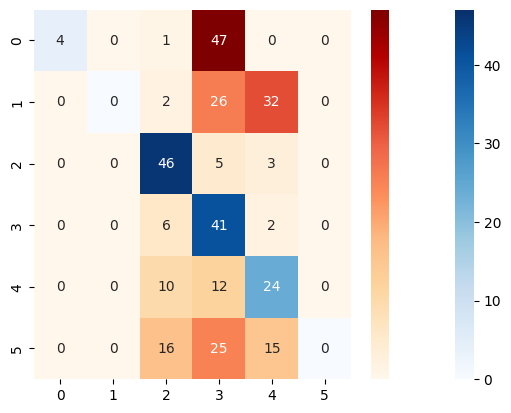

In [ ]:
import numpy as np
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred)
vmin = np.min(conf_mat)
vmax = np.max(conf_mat)


off_diag_mask = np.eye(*conf_mat.shape, dtype=bool)

fig = plt.figure()
sns.heatmap(conf_mat, annot=True, mask=~off_diag_mask, cmap='Blues',
            vmin=vmin, vmax=vmax)
sns.heatmap(conf_mat, annot=True, mask=off_diag_mask, cmap='OrRd',
            vmin=vmin, vmax=vmax, cbar_kws=dict(ticks=[]))

## Save the data

In [ ]:
torch.save(model, "/content/drive/MyDrive/PFE_Master/saved_models/save_1")

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/PFE_Master/saved_models/save_2")

In [ ]:
from transformers import VisionEncoderDecoderConfig, DonutProcessor, VisionEncoderDecoderModel, BartConfig
import torch
output_model_file = "/content/drive/MyDrive/PFE_Master/saved_models/save_1"
device  = torch.device("cuda" if torch.cuda.is_available() else "cup")
model  = VisionEncoderDecoderModel.from_pretrained(output_model_file)
model.device()

In [ ]:
BartConfig.from_pretrained(output_model_file)
VisionEncoderDecoderConfig.from_pretrained("directory")